In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from tqdm import tqdm
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from bart_compress_visualize_decode import *
from bart_representation_analysis import *
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

# Visualize ramp-to-threshold examples

In [3]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_easyr4n50_0/100.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=50)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


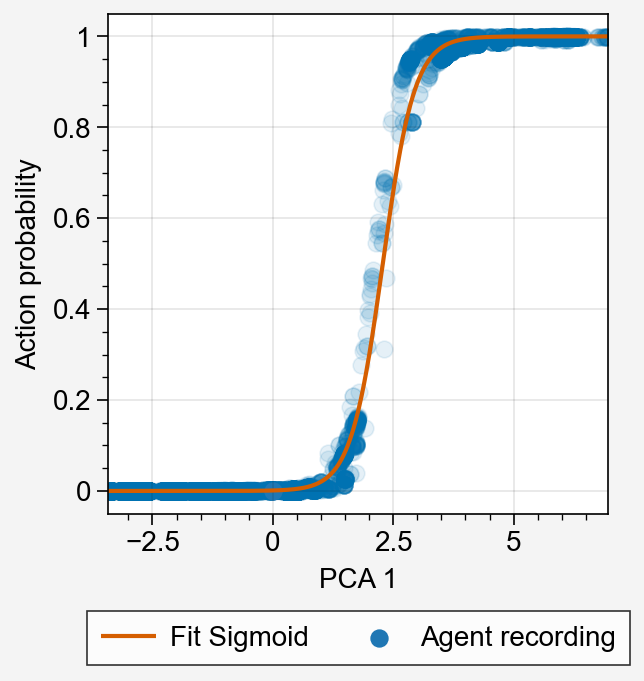

In [27]:
pcas = comb_pca(res, 'actor0')
pcas = np.vstack(pcas)
pca = pcas[:, 0].reshape(-1, 1)
actions = np.vstack(res['actions']).reshape(-1)
ap = np.vstack(res['action_probs'])[:, 1]

lr = LogisticRegression()
lr.fit(pca, actions)

fig, ax = pplt.subplots()
x = np.linspace(pca.min(), pca.max(), 1000).reshape(-1, 1)
ypred = lr.predict_proba(x)[:, 1]
ax.scatter(pca, ap, alpha=0.1)
ax.scatter(0, 0, c=rgb_colors[0], label='Agent recording')
ax.plot(x, ypred, label='Fit Sigmoid')
ax.format(xlabel='PCA 1', ylabel='Action probability')
ax.legend(loc='b')

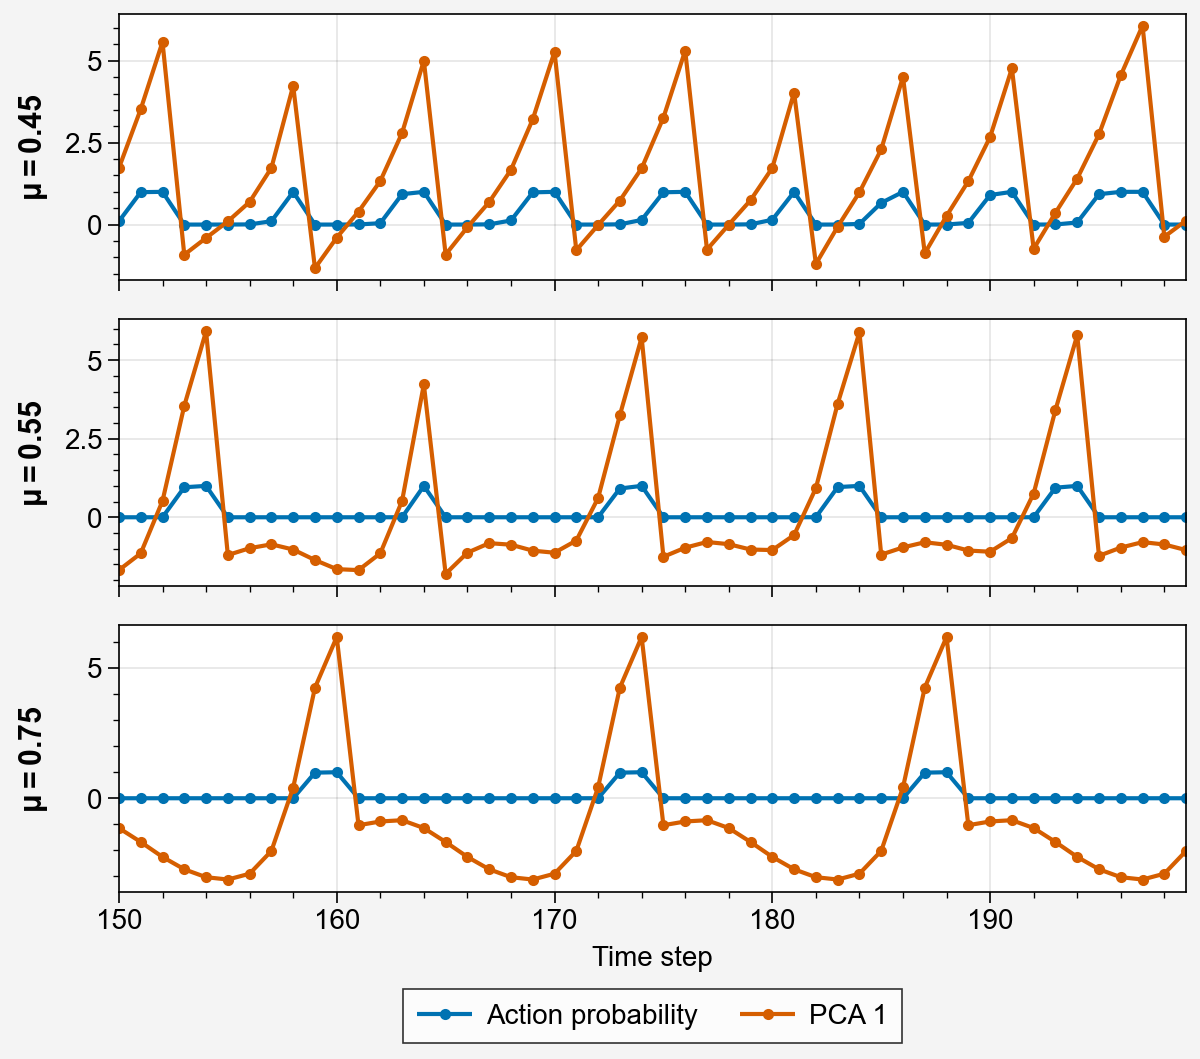

In [40]:
fig, ax = pplt.subplots(nrows=3, refaspect=4, figwidth=6)
eps = [5, 7, 11]
mus = np.arange(0.2, 1.01, 0.05)
for i, ep in enumerate(eps):
    ap = res['action_probs'][ep][:, 1]
    pca = split_by_ep(res, pcas)[ep][:, 0]
    ax[i].plot(np.arange(150, 200), ap[150:200], marker='o', markersize=3, label='Action probability')
    ax[i].plot(np.arange(150, 200), pca[150:200], marker='o', label='PCA 1', markersize=3)
ax[2].legend(loc='b')
ax.format(xlabel='Time step', leftlabels=[f'$\mu={mu:.2f}$' for mu in mus[eps]])

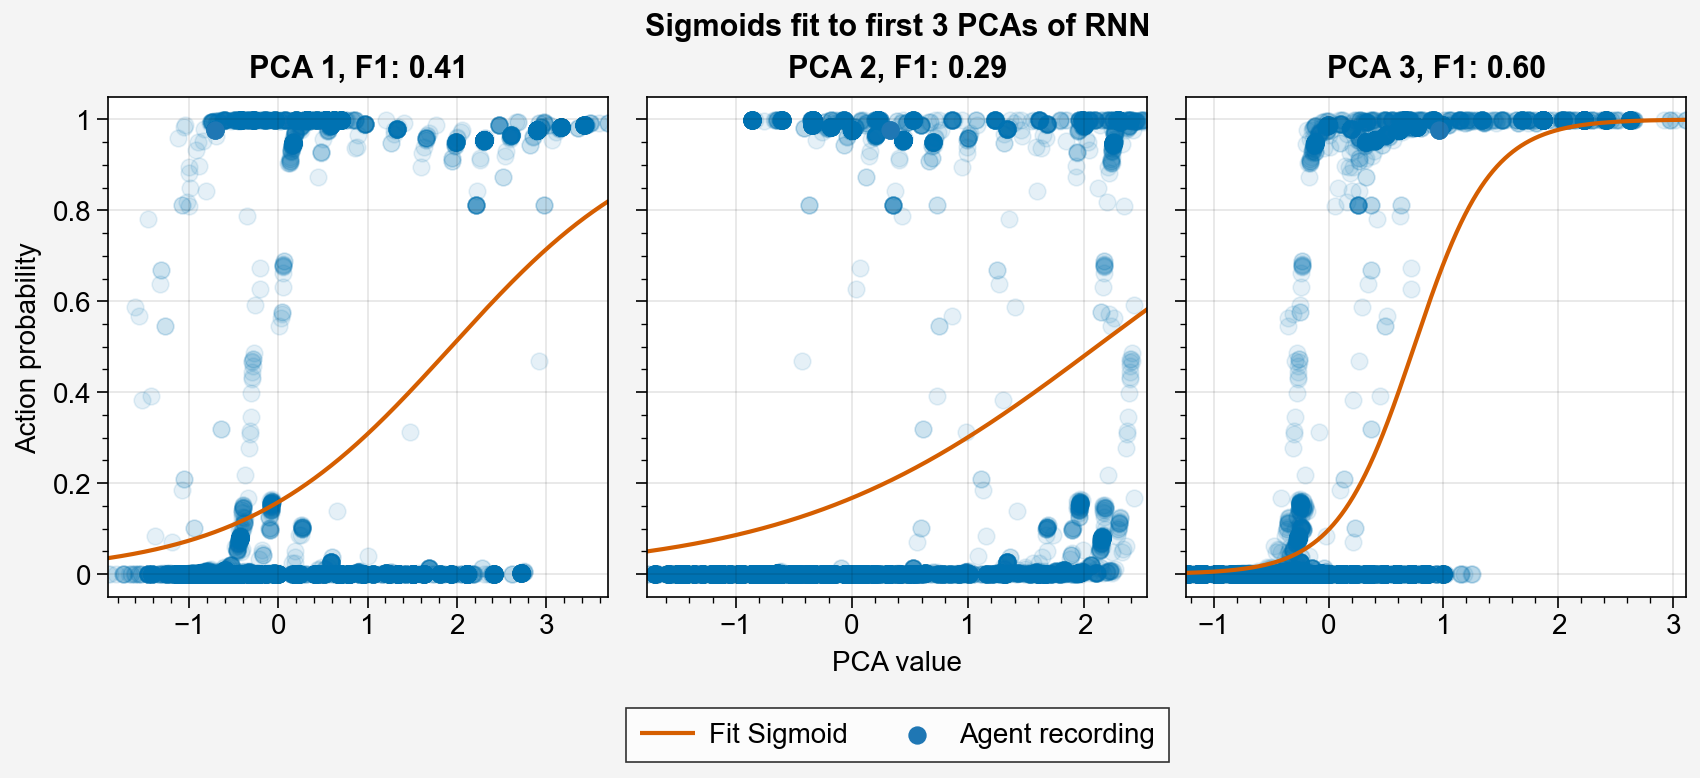

In [48]:
pcas = comb_pca(res, 'shared1')
pcas = np.vstack(pcas)
actions = np.vstack(res['actions']).reshape(-1)
ap = np.vstack(res['action_probs'])[:, 1]


fig, ax = pplt.subplots(ncols=3, sharex=True)

toplabels = []
for i in range(3):
    lines = []
    pca = pcas[:, i].reshape(-1, 1)
    lr = LogisticRegression()
    lr.fit(pca, actions)
    x = np.linspace(pca.min(), pca.max(), 1000).reshape(-1, 1)
    ypred = lr.predict_proba(x)[:, 1]
    ax[i].scatter(pca, ap, alpha=0.1)
    lines.append(ax[i].plot(x, ypred, label='Fit Sigmoid'))
    lines.append(ax[i].scatter(pca[0], ap[0], c=rgb_colors[0], label='Agent recording'))
    ypred = lr.predict(pca)
    f1 = f1_score(actions, ypred)
    toplabels.append(f'PCA {i+1}, F1: {f1:.2f}')
    
ax.format(toplabels=toplabels, ylabel='Action probability',
          suptitle='Sigmoids fit to first 3 PCAs of RNN', xlabel='PCA value')
fig.legend(lines, loc='b')

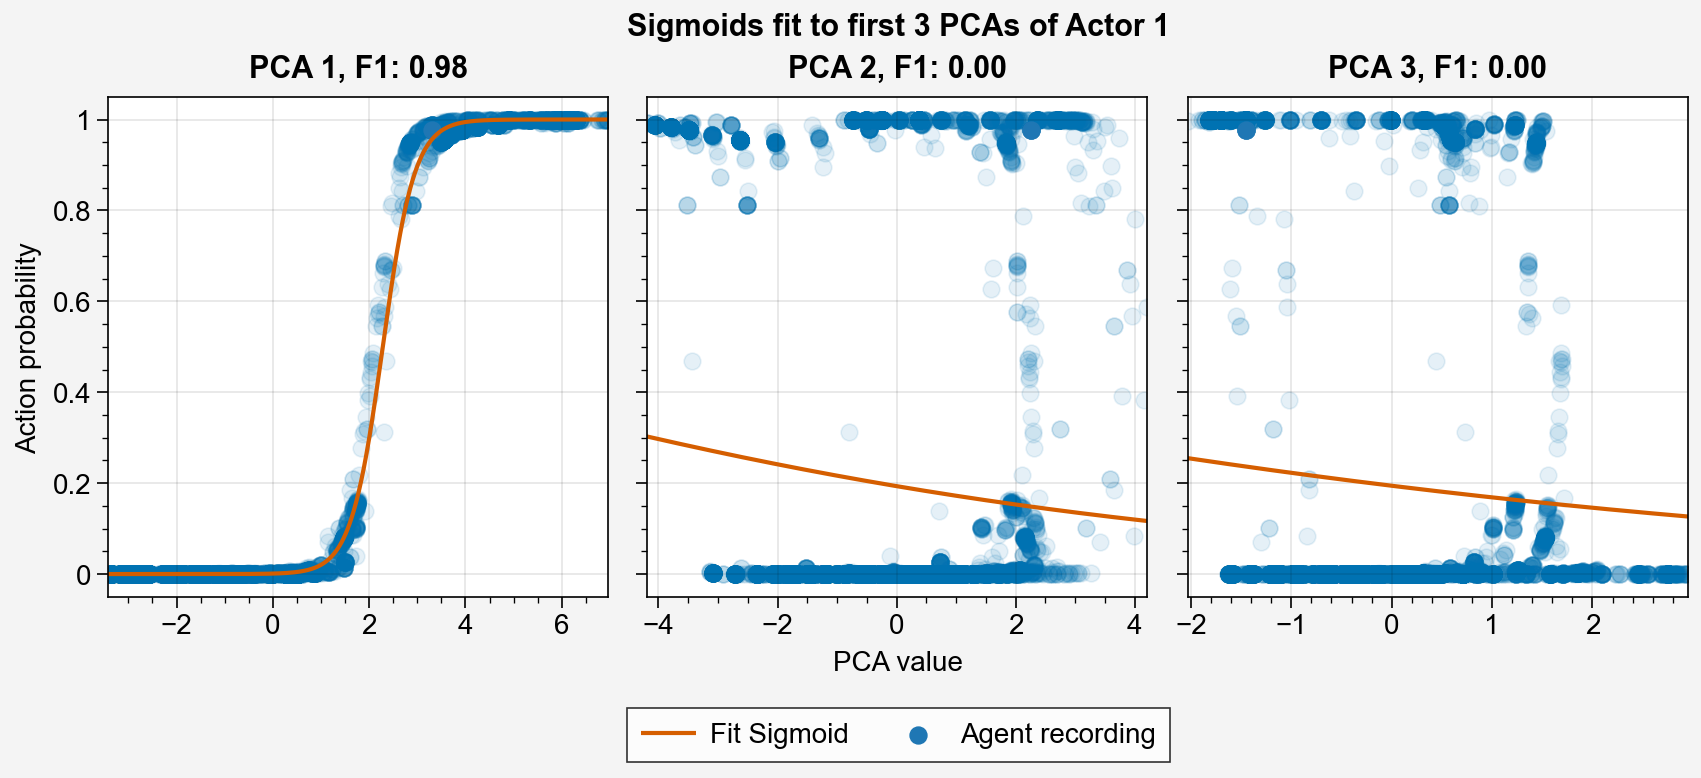

In [47]:
pcas = comb_pca(res, 'actor0')
pcas = np.vstack(pcas)
actions = np.vstack(res['actions']).reshape(-1)
ap = np.vstack(res['action_probs'])[:, 1]


fig, ax = pplt.subplots(ncols=3, sharex=True)

toplabels = []
for i in range(3):
    lines = []
    pca = pcas[:, i].reshape(-1, 1)
    lr = LogisticRegression()
    lr.fit(pca, actions)
    x = np.linspace(pca.min(), pca.max(), 1000).reshape(-1, 1)
    ypred = lr.predict_proba(x)[:, 1]
    ax[i].scatter(pca, ap, alpha=0.1)
    lines.append(ax[i].plot(x, ypred, label='Fit Sigmoid'))
    lines.append(ax[i].scatter(pca[0], ap[0], c=rgb_colors[0], label='Agent recording'))
    ypred = lr.predict(pca)
    f1 = f1_score(actions, ypred)
    toplabels.append(f'PCA {i+1}, F1: {f1:.2f}')
    
ax.format(toplabels=toplabels, ylabel='Action probability',
          suptitle='Sigmoids fit to first 3 PCAs of Actor 1',
          xlabel='PCA value')
fig.legend(lines, loc='b')

# Identify ramping signal

In [361]:

models = [
    1.0, 1.2, 1.5, 1.7, 2.0
]
postfixes = ['', 'pop0.1']

model = 1.5
t = 0
exp_name = f"p{model}n50pop0.1"
chk = 200

exp_name = f"p{model}n50"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


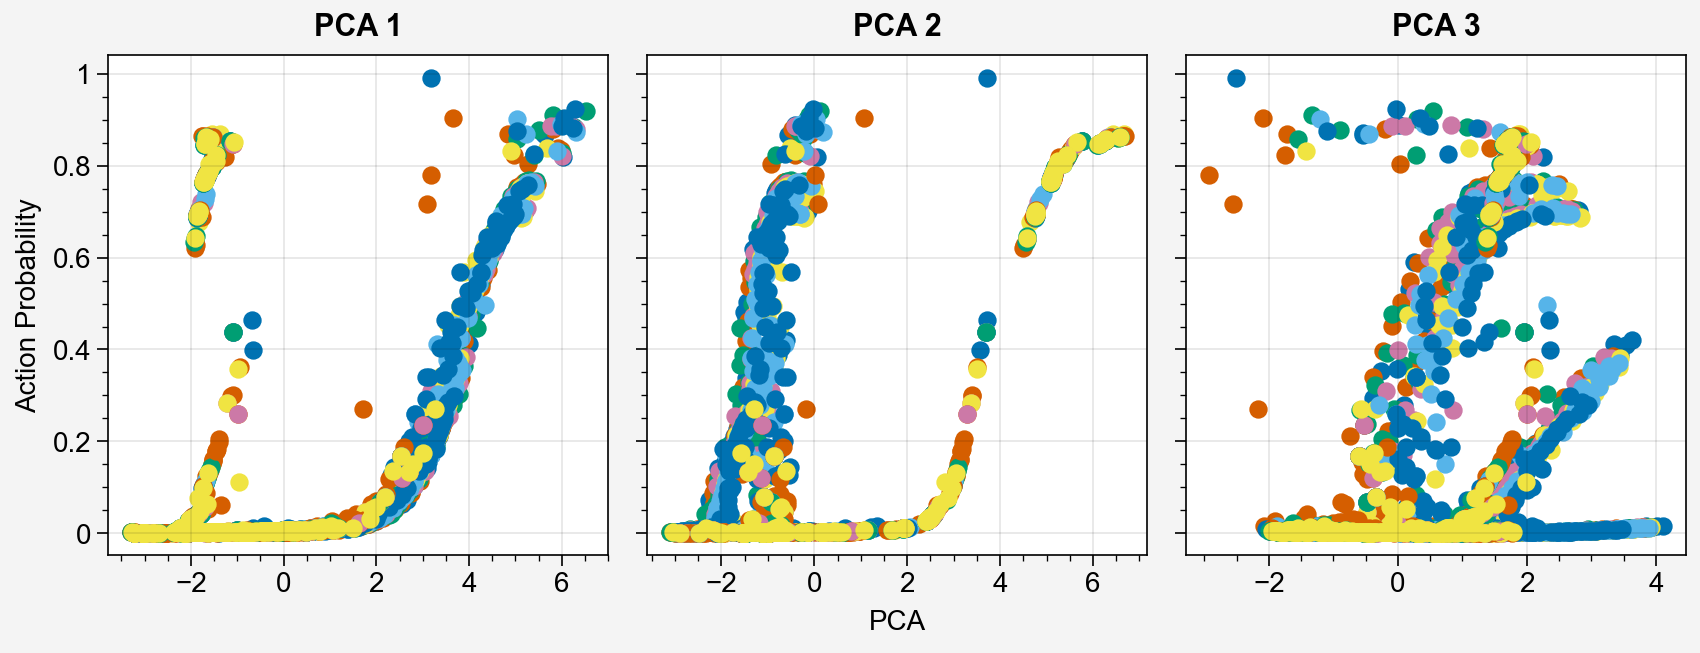

In [211]:
fig, ax = pplt.subplots(ncols=3)

pca_as = comb_pca(res, 'actor0')
starts, ends = starts_and_ends(res)

for ep in range(17):
    
    ap = res['action_probs'][ep][:, 1]
    idxs = np.full(len(ap), True)
    idxs[starts[ep]] = False
    pca_a = pca_as[ep]
    for i in range(3):
        # ax[i].scatter(pca_a[:, i], ap)
        ax[i].scatter(pca_a[idxs, i], ap[idxs])
        
ax.format(xlabel='PCA', ylabel='Action Probability',
          toplabels=['PCA 1', 'PCA 2', 'PCA 3'])

In [421]:
pickle.dump({
    'ramp_location': ramp_location,
    'ramp_r2': ramp_r2,
    'bimodal_rnn_location': bimodal_rnn_location,
    'bimodal_rnn_score': bimodal_rnn_score,
    'bimodal_actor_location': bimodal_actor_location,
    'bimodal_actor_score': bimodal_actor_score,
}, open('data/meta_pca_scores', 'wb'))

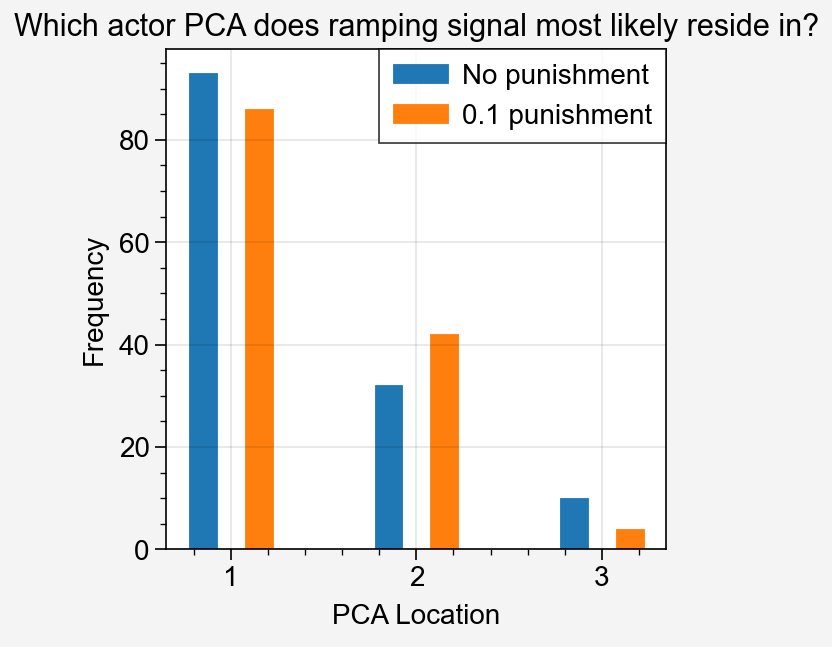

In [434]:
labels = ['No punishment', '0.1 punishment']
fig, ax = pplt.subplots()
for i in range(2): # punishment conditions
    for j in range(3):
        if j == 0:
            ax.bar(i*0.3-0.15+j, (ramp_location[i] == j).sum(), width=0.3, c=rgb_colors[i],
                   label=labels[i])
        else:
            ax.bar(i*0.3-0.15+j, (ramp_location[i] == j).sum(), width=0.3, c=rgb_colors[i])
ax.format(xlocator=range(3), xformatter=['1', '2', '3'], xlabel='PCA Location',
          ylabel='Frequency', title='Which actor PCA does ramping signal most likely reside in?')
ax.legend(ncols=1)

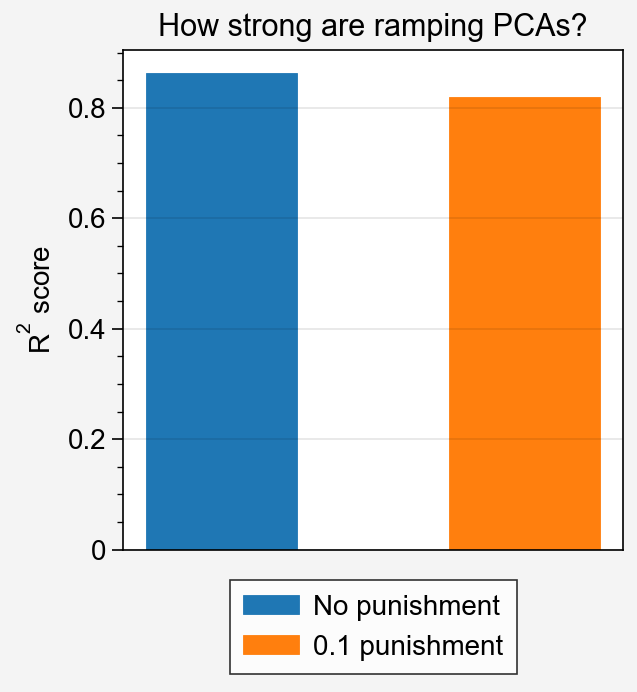

In [439]:
labels = ['No punishment', '0.1 punishment']
fig, ax = pplt.subplots() 
for i in range(2): # punishment conditions
    ax.bar(i*0.3-0.15+j, (ramp_r2[i]).mean(), width=0.3, c=rgb_colors[i],
            label=labels[i])
ax.format(xlocator=[], xformatter=['1', '2', '3'], xlabel='',
          ylabel='$R^2$ score', title='How strong are ramping PCAs?')
ax.legend(ncols=1, loc='b')

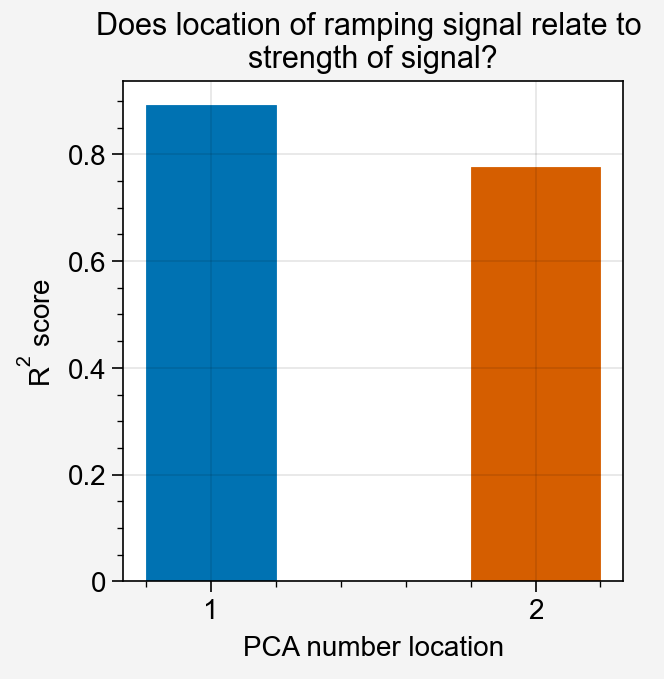

In [511]:
fig, ax = pplt.subplots()
for i in range(2): # pca locaions
    model_idxs = (ramp_location == i)
    ax.bar(i, ramp_r2[model_idxs].mean())
 
ax.format(xlocator=range(2), xformatter=['1', '2'], xlabel='PCA number location',
          title='Does location of ramping signal relate to \nstrength of signal?',
          ylabel='$R^2$ score')

p1.0n50 1 210 0.9960572605814645


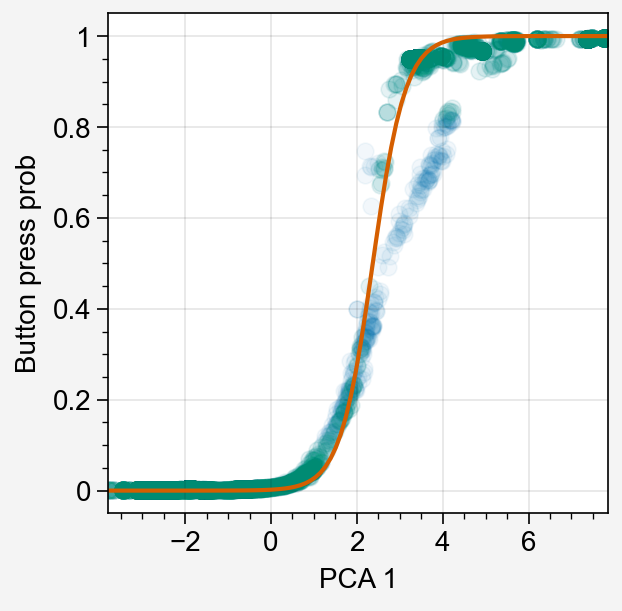

In [575]:
idxs = np.stack(np.unravel_index((-ramp_r2).reshape(-1).argsort(), ramp_r2.shape)).T
idx = idxs[2]
postfix = postfixes[idx[0]]
model = models[idx[1]]
t = trials[idx[2]]
chk = chks[idx[3]]

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)

pca_as = comb_pca(res, 'actor0')
x, x0, k, ypred, r2_indiv, r2 = fit_ramp(res, pca=0, plot=True)
print(exp_name, t, chk, r2)

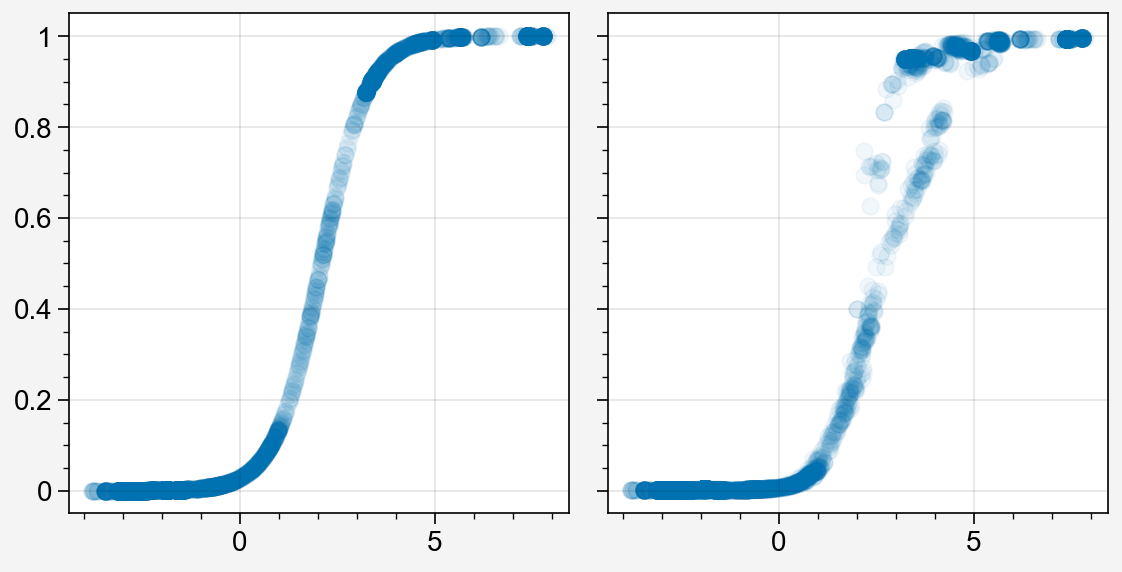

In [626]:
fig, ax = pplt.subplots(ncols=3)
probs = lm.predict_proba(pcas[:, 0].reshape(-1, 1))[:, 1]
ax[0].scatter(pcas[:, 0], probs, alpha=0.05)
probs = np.vstack(res['action_probs'])[:, 1]
ax[1].scatter(pcas[:, 0], probs, alpha=0.05)
ax[2].scatter()

# Conclusions about ramping signal through punishments and models

In [3]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

In [ ]:
res['ramp_f1s']

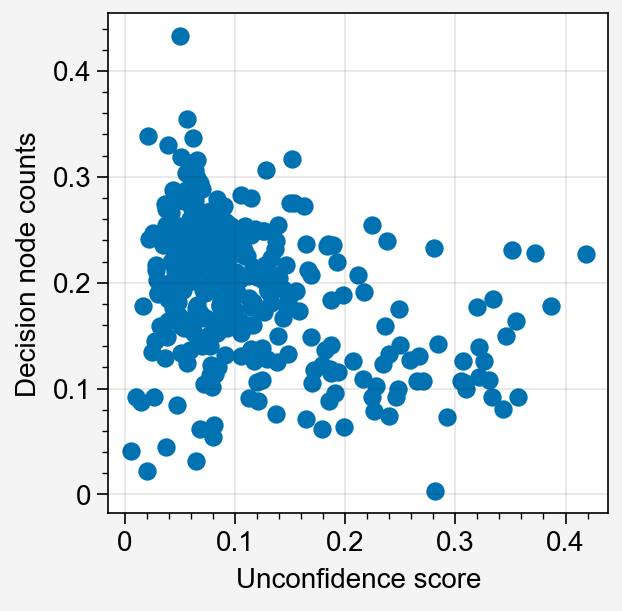

In [821]:
fig, ax = pplt.subplots()
dec = all_decision_nodes.mean(axis=(4, 5))
unconf = unconfidence_scores
ax.scatter(unconf.reshape(-1), dec.reshape(-1))
ax.format(xlabel='Unconfidence score', ylabel='Decision node counts')

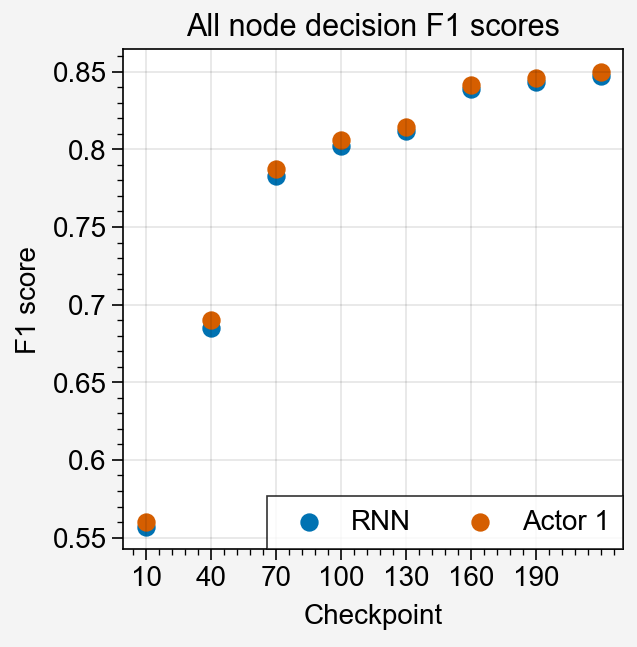

In [865]:
fig, ax = pplt.subplots()
labels = ['RNN', 'Actor 1']
for i, layer in enumerate([1, 2]):
    ax.scatter(ramp_f1s[:, :, :, :, layer, 0].mean(axis=(0, 1, 2)),
               label=labels[i])
    
ax.legend()
ax.format(xlabel='Checkpoint', xlocator=range(7), 
          xformatter=[str(c) for c in chks], ylabel='F1 score',
          title='All node decision F1 scores')

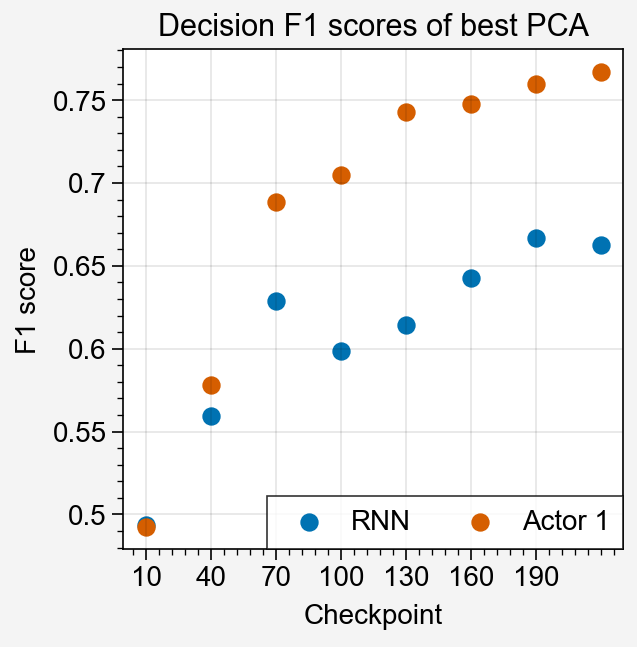

In [873]:
fig, ax = pplt.subplots()
labels = ['RNN', 'Actor 1']
for i, layer in enumerate([1, 2]):
    ax.scatter(ramp_f1s[:, :, :, :, layer, 1:].max(axis=4).mean(axis=(0, 1, 2)),
               label=labels[i])
    
ax.legend(loc='lr')
ax.format(xlabel='Checkpoint', xlocator=range(7), 
          xformatter=[str(c) for c in chks], ylabel='F1 score',
          title='Decision F1 scores of best PCA')

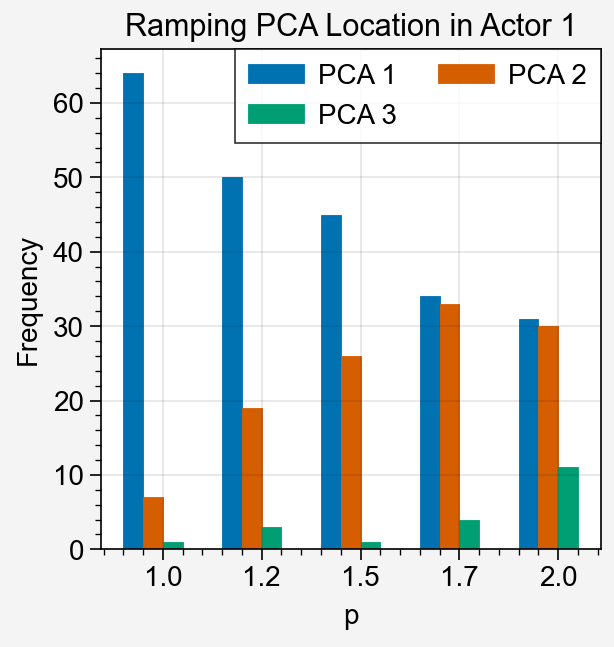

In [856]:
fig, ax = pplt.subplots()
for i in range(3):
    ax.bar(np.arange(5)+0.2*i, 
           (ramp_f1s[:, :, :, :, 2, 1:].argmax(axis=4) == i).sum(axis=(0, 2, 3)),
           width=0.2, label=f'PCA {i+1}')
ax.format(xlabel='p', xlocator=np.arange(5)+0.3, xformatter=[str(p) for p in models],
          ylabel='Frequency',
          title='Ramping PCA Location in Actor 1')
ax.legend(loc='ur', ncols=2)

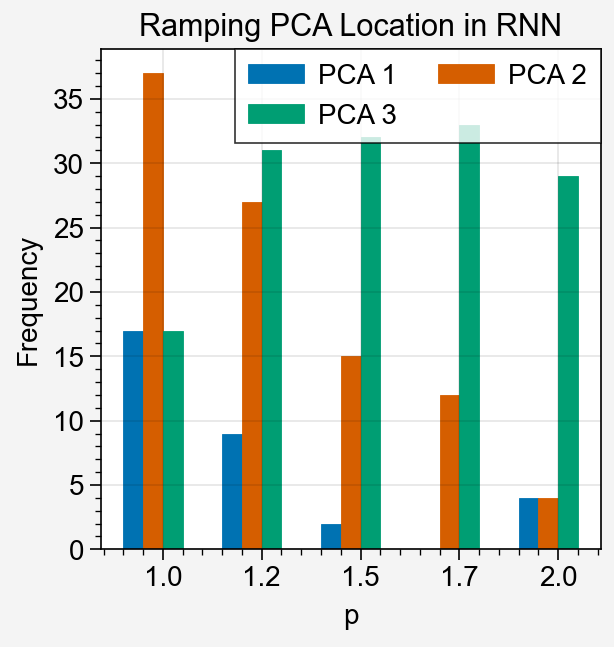

In [857]:
fig, ax = pplt.subplots()
for i in range(3):
    ax.bar(np.arange(5)+0.2*i, 
           (ramp_f1s[:, :, :, :, 1, 1:].argmax(axis=4) == i).sum(axis=(0, 2, 3)),
           width=0.2, label=f'PCA {i+1}')
ax.format(xlabel='p', xlocator=np.arange(5)+0.3, xformatter=[str(p) for p in models],
          ylabel='Frequency',
          title='Ramping PCA Location in RNN')
ax.legend(loc='ur', ncols=2)

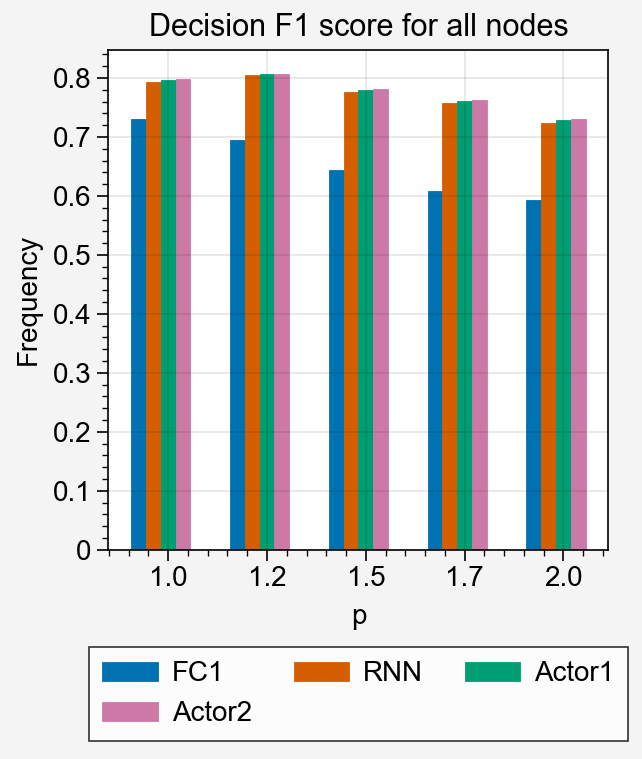

In [860]:
fig, ax = pplt.subplots()
labels = ['FC1', 'RNN', 'Actor1', 'Actor2']
for i in range(4):
    
    ax.bar(np.arange(5)+0.15*i, 
           ramp_f1s[:, :, :, :, i, 0].mean(axis=(0, 2, 3)),
           label=labels[i],
           width=0.15)
ax.format(xlabel='p', xlocator=np.arange(5)+0.3, xformatter=[str(p) for p in models],
          ylabel='Frequency',
          title='Decision F1 score for all nodes')
ax.legend(loc='b')

<BarContainer object of 3 artists>

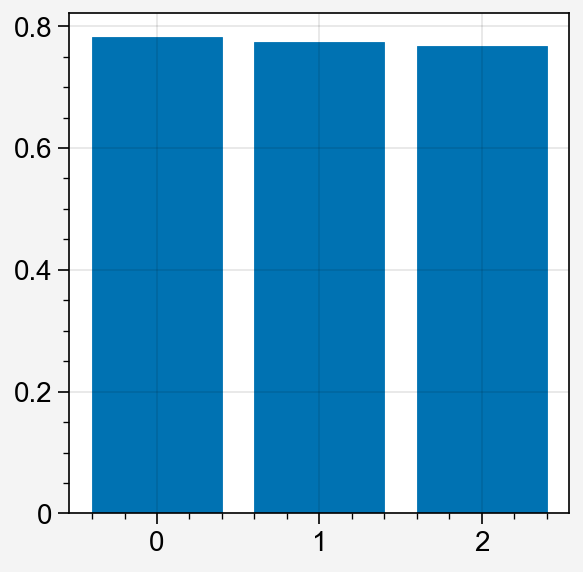

In [862]:
fig, ax = pplt.subplots()
ax.bar(ramp_f1s[:, :, :, :, 2, 0].mean(axis=(1, 2, 3)))

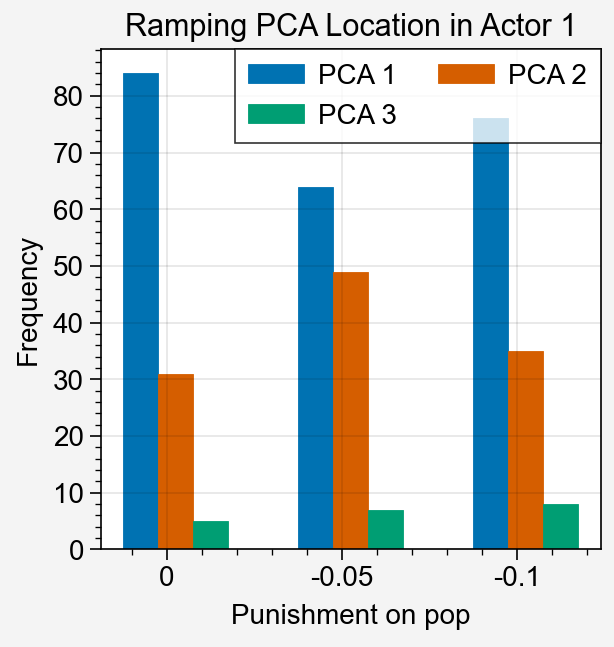

In [876]:
fig, ax = pplt.subplots()
for i in range(3):
    ax.bar(np.arange(3)+0.2*i, 
           (ramp_f1s[:, :, :, :, 2, 1:].argmax(axis=4) == i).sum(axis=(1, 2, 3)),
           width=0.2, label=f'PCA {i+1}')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(5)+0.15, xformatter=['0', '-0.05', '-0.1'],
          ylabel='Frequency',
          title='Ramping PCA Location in Actor 1')
ax.legend(loc='ur', ncols=2)

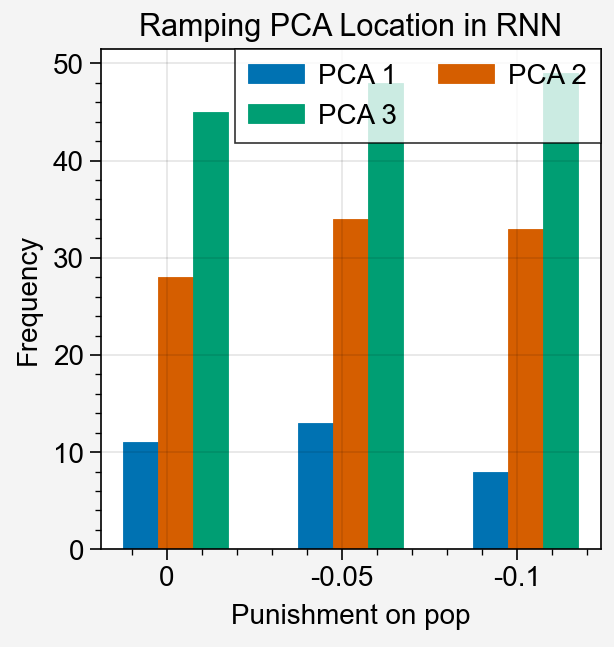

In [877]:
fig, ax = pplt.subplots()
for i in range(3):
    ax.bar(np.arange(3)+0.2*i, 
           (ramp_f1s[:, :, :, :, 1, 1:].argmax(axis=4) == i).sum(axis=(1, 2, 3)),
           width=0.2, label=f'PCA {i+1}')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(5)+0.15, xformatter=['0', '-0.05', '-0.1'],
          ylabel='Frequency',
          title='Ramping PCA Location in RNN')
ax.legend(loc='ur', ncols=2)

## Calculating with giverew

- No clear effect of popping on location of ramp decision
- Increasing $p$ slightly moves actor ramp from PCA1 to 2
    - Interestingly, effect is even more pronounced when using first to 275 agents
- Showing reward info seems to stabilize behavior, making decision ramp much more central (PCA1) in both RNN and actor, still the case when using first to 275

In [3]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

In [5]:
np.array(list(res.keys()))

array(['last_sizes', 'unpopped_sizes', 'pop_rate', 'rewards', 'values',
       'action_probs', 'all_lens', 'all_num_balloons', 'dec_flow_scores',
       'iterators_idxs', 'sizes', 'ramp_f1s', 'ramp_indiv_contribs',
       'confidence_scores', 'unconfidence_scores', 'unconfident_points',
       'step_count', 'all_decision_nodes', 'cluster_regressor_coefs',
       'cluster_regressor_scores', 'cluster_ks', 'pca_regressor_coefs',
       'pca_regressor_scores'], dtype='<U24')

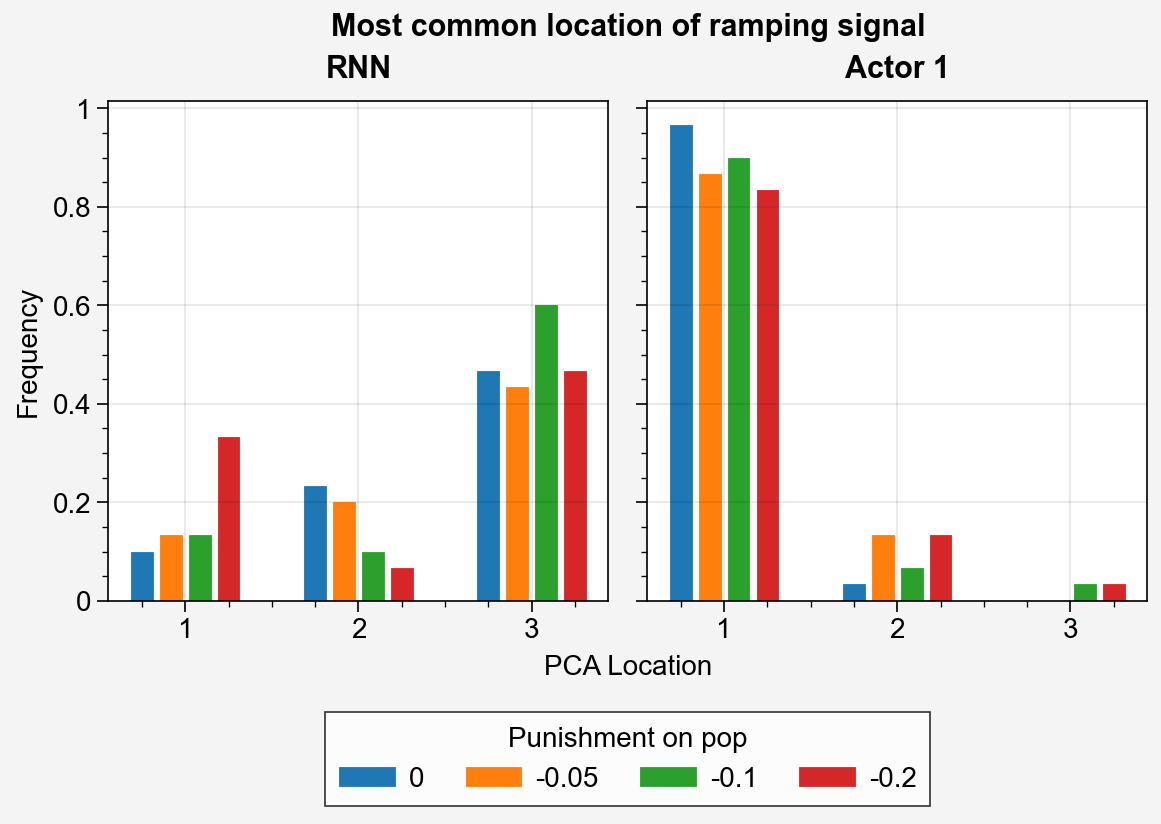

In [37]:
ramp_f1s = res['ramp_f1s']
ramp_locations = ramp_f1s[:, :, :, :, :, :, 1:].argmax(axis=-1)

layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

fig, ax = pplt.subplots(ncols=2)

bars = []
for l, layer in enumerate(layers):
    for j in range(len(pop_labels)):
        n = len(pop_labels)
        
        f1_loc = ramp_locations[:, :, :, :, :, layer]
        f1_loc = select_idxs(f1_loc)[:, j, :, :].reshape(-1)

        for i in range(3):
            y = (f1_loc == i).sum() / len(f1_loc)
            bar = ax[l].bar(i*(n+2) + j, y, c=rgb_colors[j], label=pop_labels[j],
                            width=1.5)
            if i == 0 and l == 0:
                bars.append(bar)

fig.legend(bars, loc='b', ncols=4, title=pop_axis)
ax.format(xlabel='PCA Location', xformatter=['1', '2', '3'], 
          xlocator=np.arange(3)*(n+2)+1.5,
          ylabel='Frequency', toplabels=layer_labels,
          suptitle='Most common location of ramping signal')


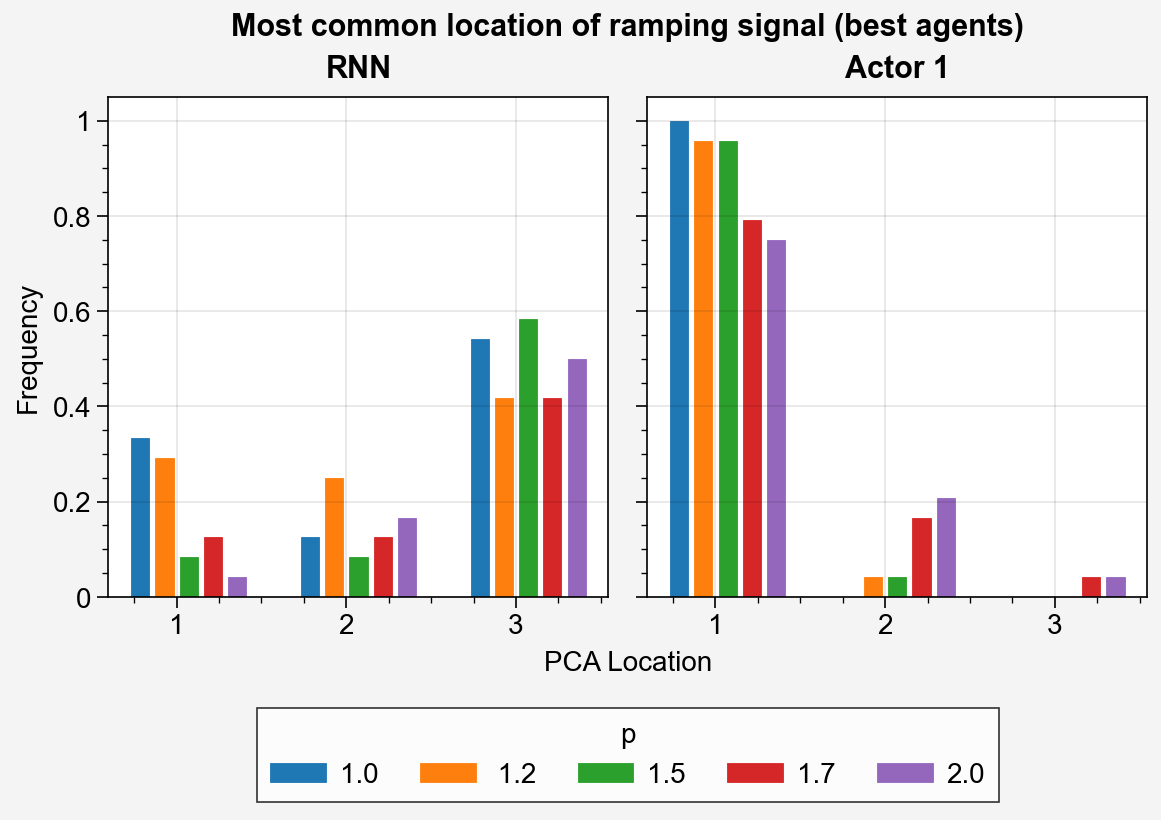

In [46]:
ramp_f1s = res['ramp_f1s']
ramp_locations = ramp_f1s[:, :, :, :, :, :, 1:].argmax(axis=-1)

layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

fig, ax = pplt.subplots(ncols=2)

bars = []
for l, layer in enumerate(layers):
    for j in range(len(p_labels)):
        n = len(p_labels)
        
        f1_loc = ramp_locations[:, :, :, :, :, layer]
        f1_loc = select_idxs(f1_loc, 'best')[:, :, j, :].reshape(-1)

        for i in range(3):
            y = (f1_loc == i).sum() / len(f1_loc)
            bar = ax[l].bar(i*(n+2) + j, y, c=rgb_colors[j], label=p_labels[j],
                            width=1.5)
            if i == 0 and l == 0:
                bars.append(bar)

fig.legend(bars, loc='b', ncols=5, title=p_axis)
ax.format(xlabel='PCA Location', xformatter=['1', '2', '3'], 
          xlocator=np.arange(3)*(n+2)+1.5,
          ylabel='Frequency', toplabels=layer_labels,
          suptitle='Most common location of ramping signal (best agents)')


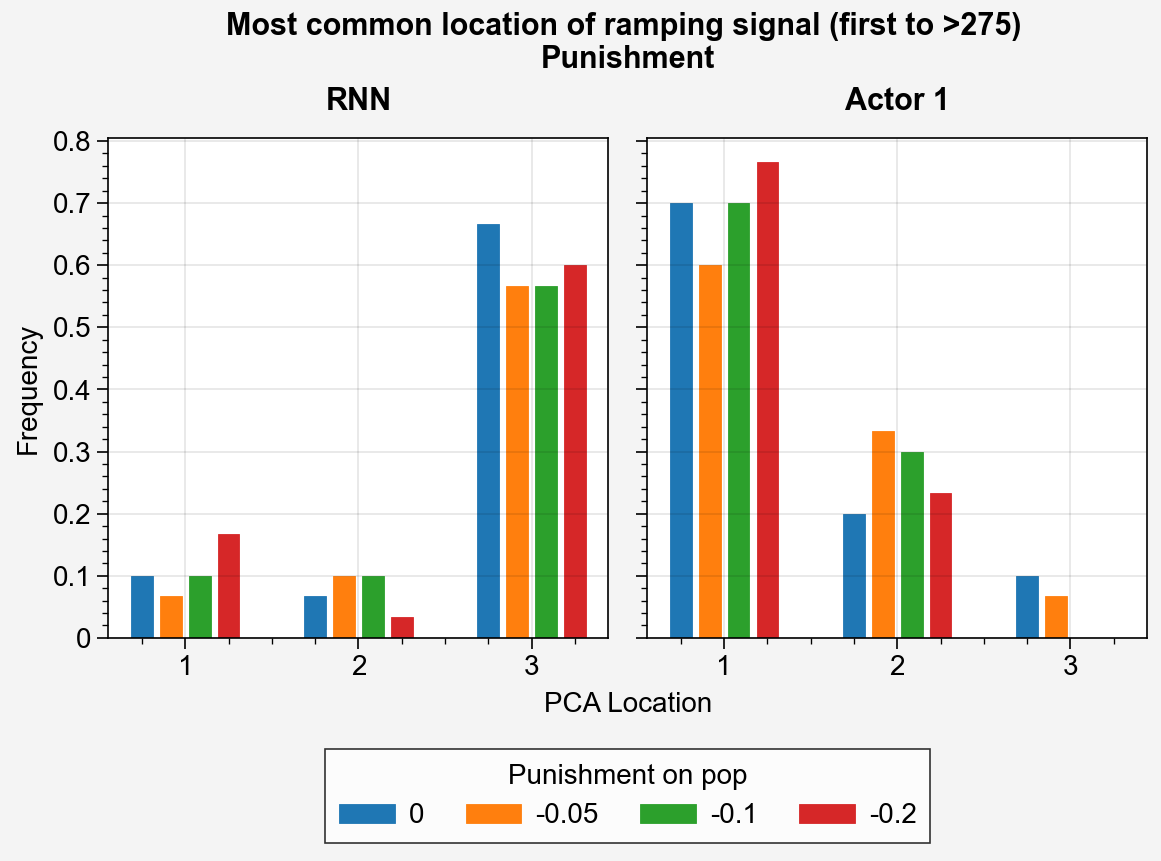

In [54]:
ramp_f1s = res['ramp_f1s']
ramp_locations = ramp_f1s[:, :, :, :, :, :, 1:].argmax(axis=-1)

layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

fig, ax = pplt.subplots(ncols=2)

bars = []
for l, layer in enumerate(layers):
    for j in range(len(pop_labels)):
        n = len(pop_labels)
        
        f1_loc = ramp_locations[:, :, :, :, :, layer]
        f1_loc = select_idxs(f1_loc, 'first')[:, j, :, :].reshape(-1)

        for i in range(3):
            y = (f1_loc == i).sum() / len(f1_loc)
            bar = ax[l].bar(i*(n+2) + j, y, c=rgb_colors[j], label=pop_labels[j],
                            width=1.5)
            if i == 0 and l == 0:
                bars.append(bar)

fig.legend(bars, loc='b', ncols=4, title=pop_axis)
ax.format(xlabel='PCA Location', xformatter=['1', '2', '3'], 
          xlocator=np.arange(3)*(n+2)+1.5,
          ylabel='Frequency', toplabels=layer_labels,
          suptitle='Most common location of ramping signal (first to >275) \nPunishment')


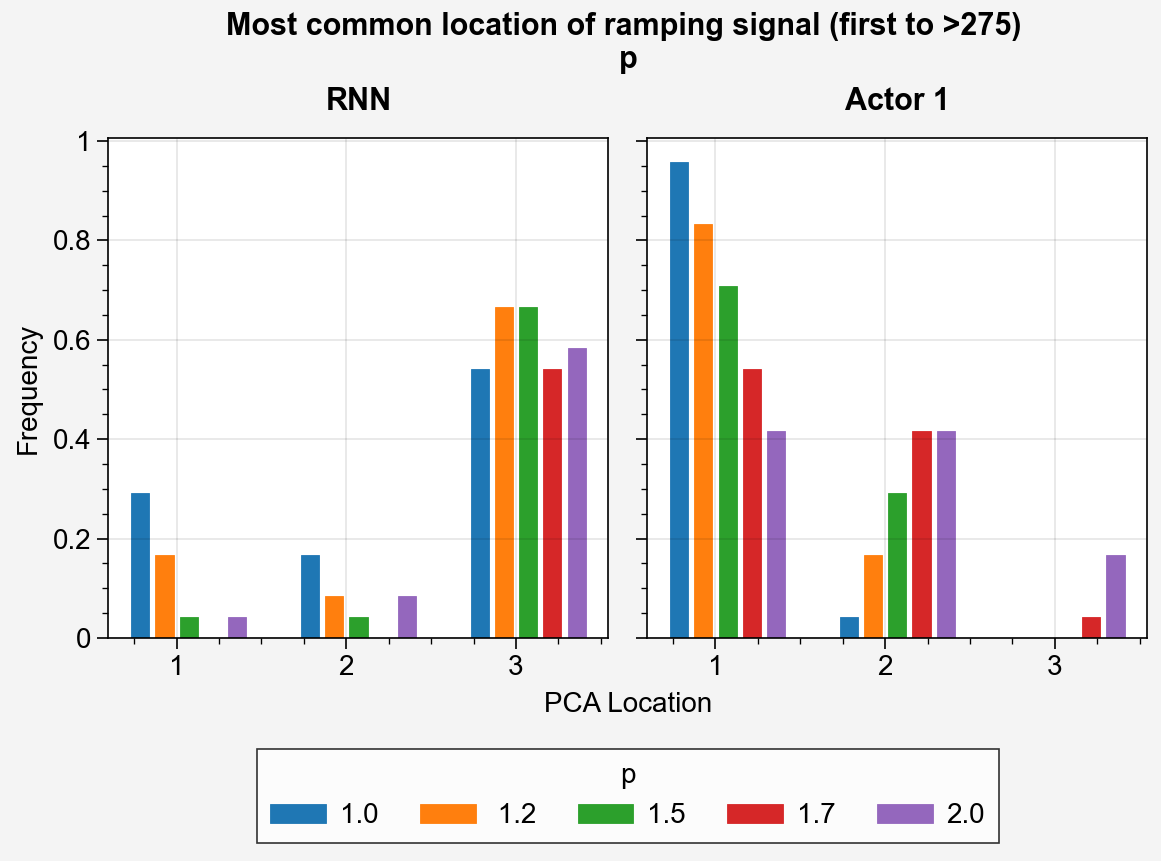

In [55]:
ramp_f1s = res['ramp_f1s']
ramp_locations = ramp_f1s[:, :, :, :, :, :, 1:].argmax(axis=-1)

layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

fig, ax = pplt.subplots(ncols=2)

bars = []
for l, layer in enumerate(layers):
    for j in range(len(p_labels)):
        n = len(p_labels)
        
        f1_loc = ramp_locations[:, :, :, :, :, layer]
        f1_loc = select_idxs(f1_loc, 'first')[:, :, j, :].reshape(-1)

        for i in range(3):
            y = (f1_loc == i).sum() / len(f1_loc)
            bar = ax[l].bar(i*(n+2) + j, y, c=rgb_colors[j], label=p_labels[j],
                            width=1.5)
            if i == 0 and l == 0:
                bars.append(bar)

fig.legend(bars, loc='b', ncols=5, title=p_axis)
ax.format(xlabel='PCA Location', xformatter=['1', '2', '3'], 
          xlocator=np.arange(3)*(n+2)+1.5,
          ylabel='Frequency', toplabels=layer_labels,
          suptitle='Most common location of ramping signal (first to >275) \np')


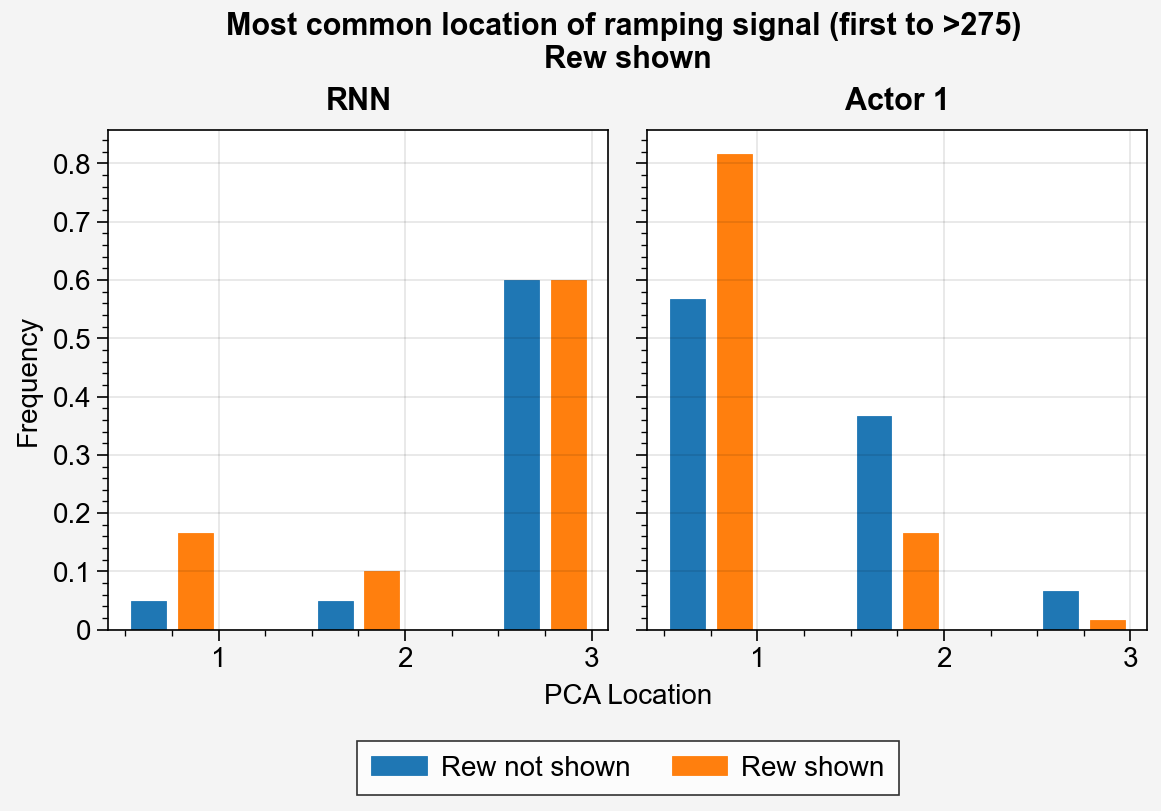

In [56]:
ramp_f1s = res['ramp_f1s']
ramp_locations = ramp_f1s[:, :, :, :, :, :, 1:].argmax(axis=-1)

layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

fig, ax = pplt.subplots(ncols=2)

bars = []
for l, layer in enumerate(layers):
    for j in range(len(give_labels)):
        n = len(give_labels)
        
        f1_loc = ramp_locations[:, :, :, :, :, layer]
        f1_loc = select_idxs(f1_loc, 'first')[j, :, :, :].reshape(-1)

        for i in range(3):
            y = (f1_loc == i).sum() / len(f1_loc)
            bar = ax[l].bar(i*(n+2) + j, y, c=rgb_colors[j], label=give_labels[j],
                            width=1.5)
            if i == 0 and l == 0:
                bars.append(bar)

fig.legend(bars, loc='b', ncols=4)
ax.format(xlabel='PCA Location', xformatter=['1', '2', '3'], 
          xlocator=np.arange(3)*(n+2)+1.5,
          ylabel='Frequency', toplabels=layer_labels,
          suptitle='Most common location of ramping signal (first to >275) \nRew shown')


### F1 scores

Nothin too new when adding the Reward shown agents. No strong trends in the F1 scores of PCA or nodes with any training conditions, meaning the main finding we're getting here is that the overall importance of the representation in the population activity changes based on training condition, but not how strong of a ramping signal exists

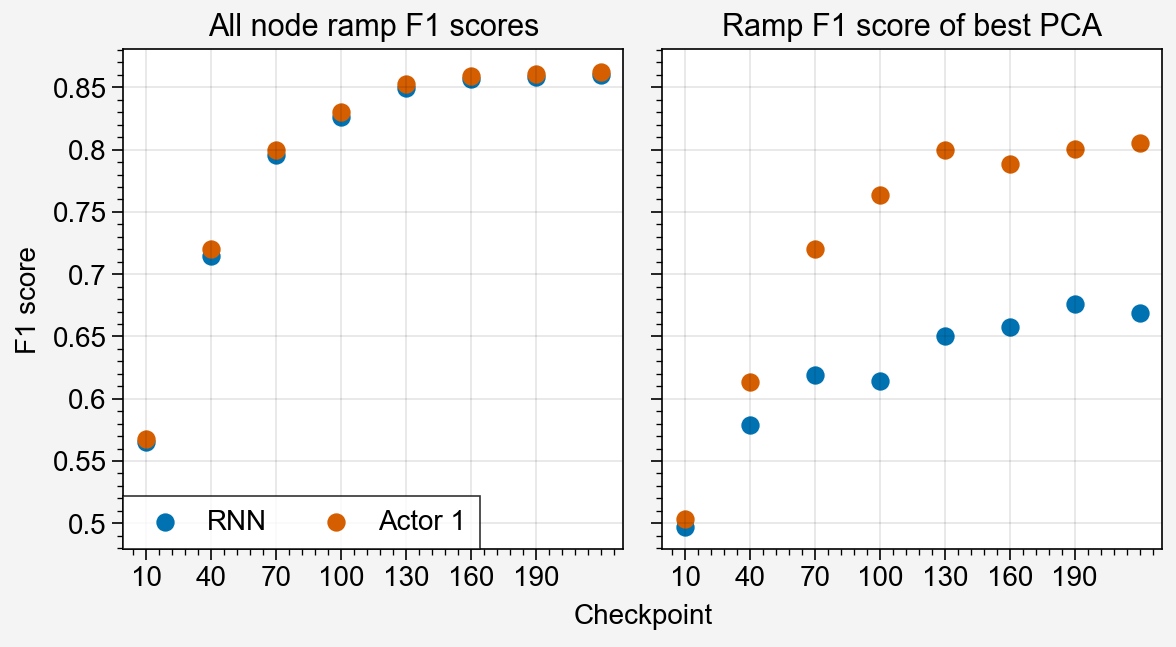

In [66]:
ramp_f1s = res['ramp_f1s']
node_f1s = ramp_f1s[:, :, :, :, :, :, 0]
best_f1s = ramp_f1s[:, :, :, :, :, :, 1:].max(axis=-1)

fig, ax = pplt.subplots(ncols=2)
labels = ['RNN', 'Actor 1']
for i, layer in enumerate([1, 2]):
    ramp = node_f1s[:, :, :, :, :, layer]
    ax[0].scatter(ramp.mean(axis=(0, 1, 2, 3)),
               label=labels[i])
    
    best = best_f1s[:, :, :, :, :, layer]
    ax[1].scatter(best.mean(axis=(0, 1, 2, 3)))
    
ax[0].legend()
ax.format(xlabel='Checkpoint', xlocator=range(7), 
          xformatter=[str(c) for c in chks], ylabel='F1 score',
          title='All node ramp F1 scores')
ax[1].format(title='Ramp F1 score of best PCA')

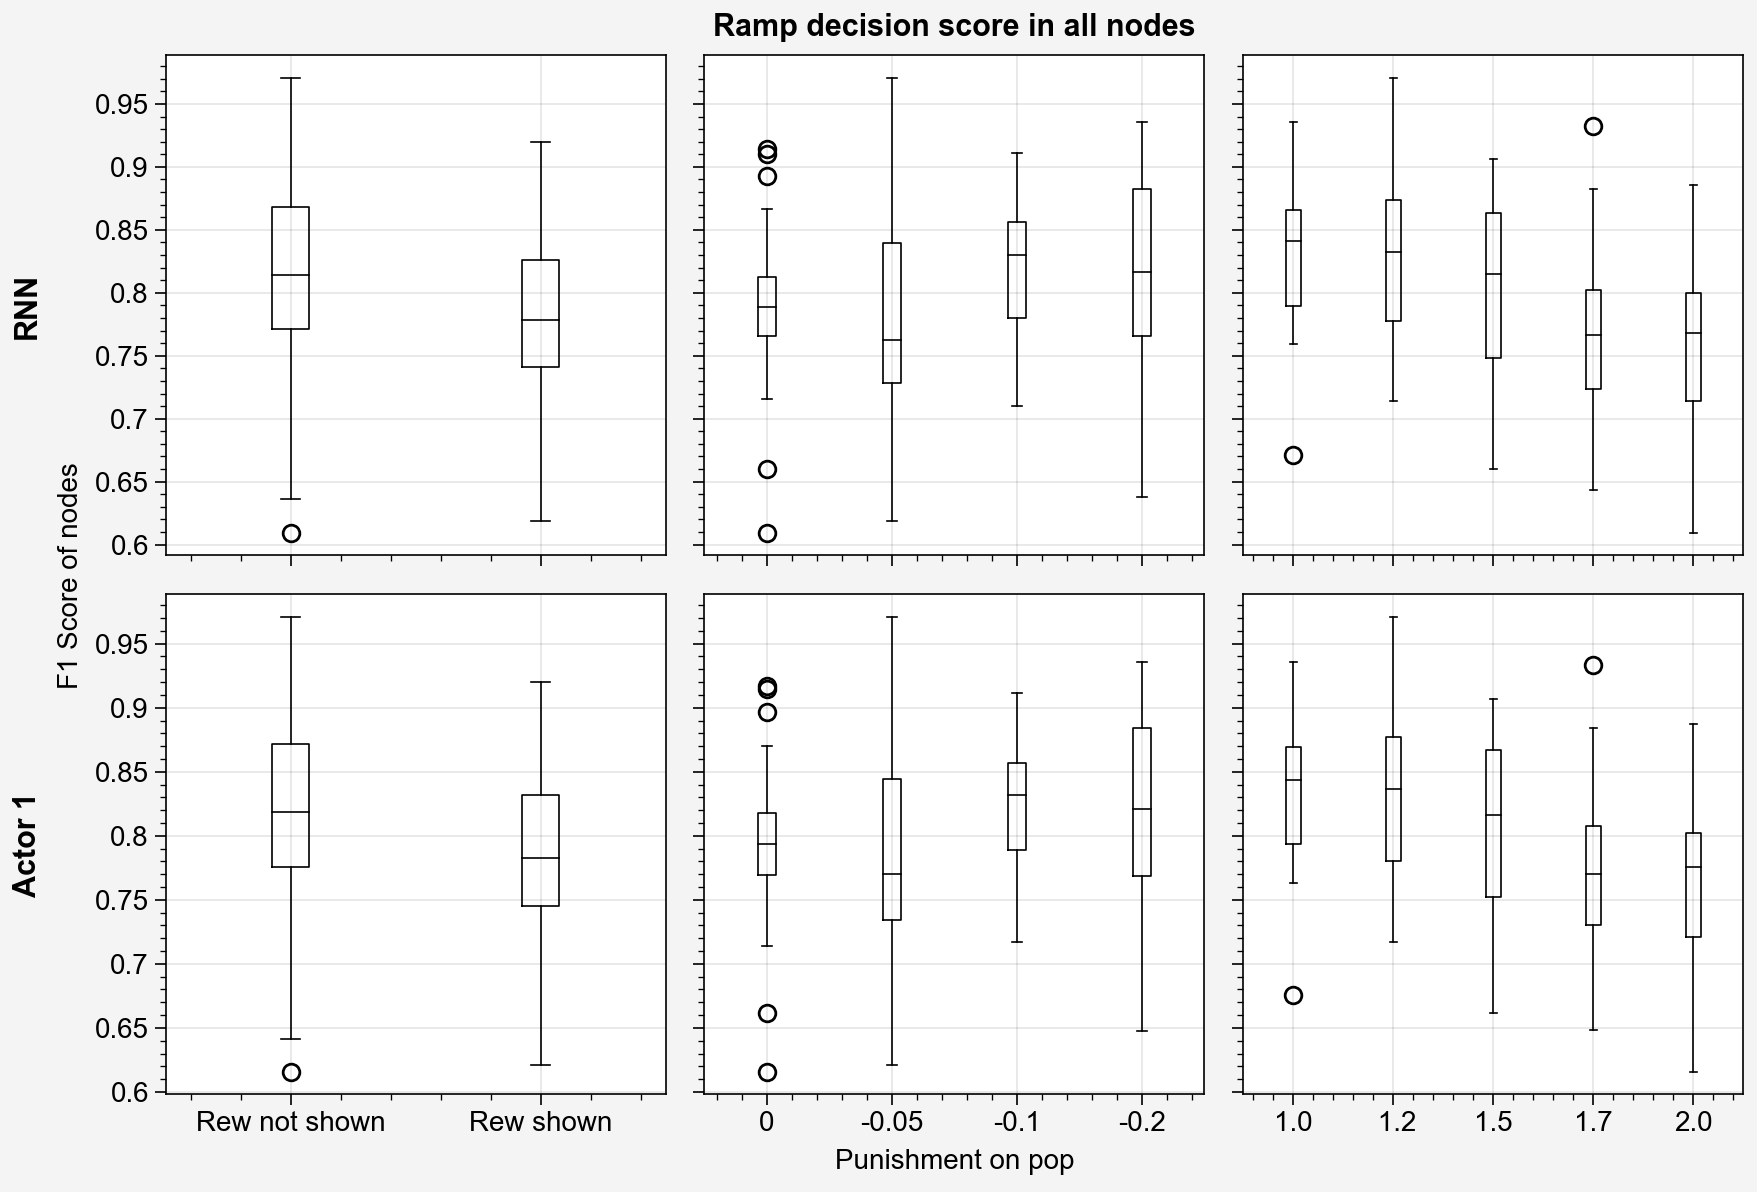

In [73]:
ramp_f1s = res['ramp_f1s']
node_f1s = ramp_f1s[:, :, :, :, :, :, 0]
best_f1s = ramp_f1s[:, :, :, :, :, :, 1:].max(axis=-1)

fig, ax = pplt.subplots(nrows=2, ncols=3)
layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

for j, layer in enumerate(layers):
    node = node_f1s[:, :, :, :, :, layer]
    best = best_f1s[:, :, :, :, :, layer]
    node = select_idxs(node, 'first')
    best = select_idxs(best, 'first')
    for i in range(2):
        ax[j, 0].boxplot(i, node[i].reshape(-1))
        ax[j, 0].format(xlocator=range(2), xformatter=give_labels)
    for i in range(4):
        ax[j, 1].boxplot(i, node[:, i].reshape(-1))
        ax[j, 1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
    for i in range(5):
        ax[j, 2].boxplot(i, node[:, :, i].reshape(-1))
        ax[j, 2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

ax.format(leftlabels=layer_labels, ylabel='F1 Score of nodes',
          suptitle='Ramp decision score in all nodes')

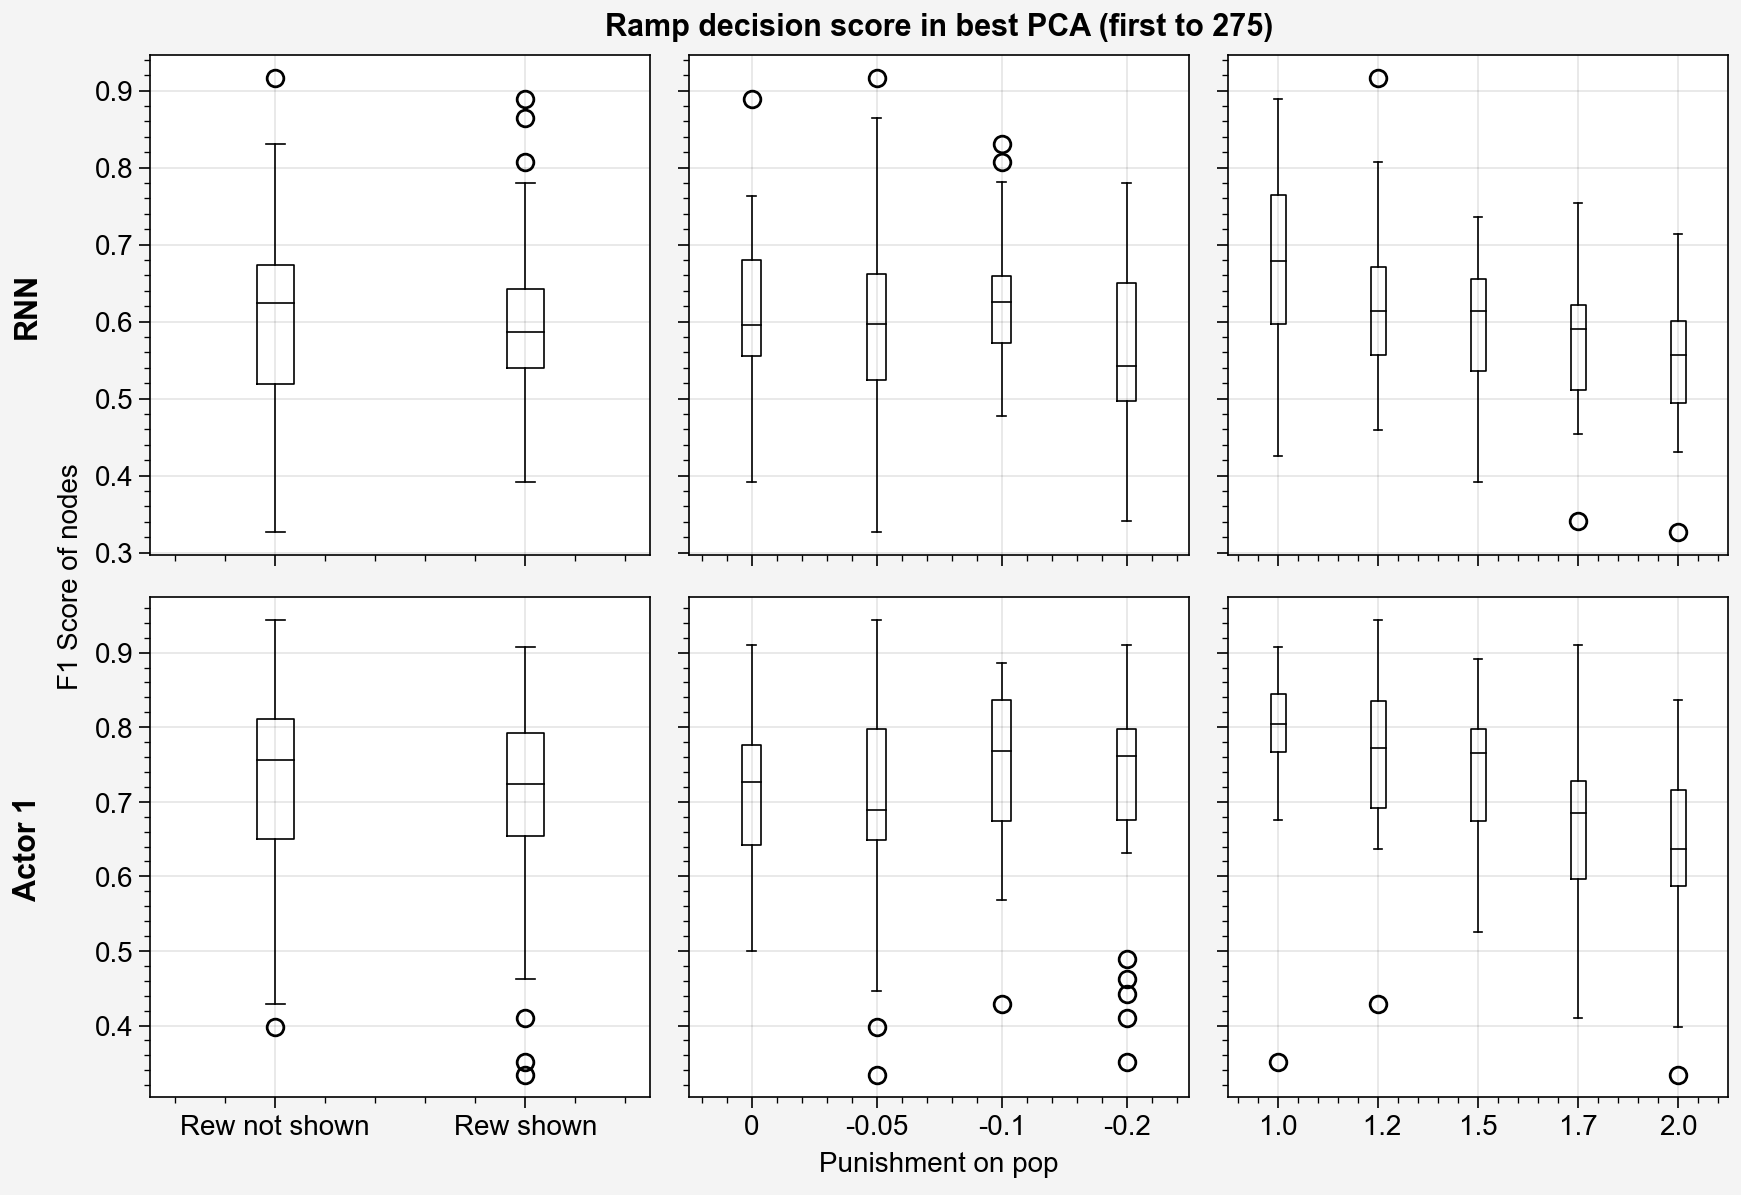

In [74]:
ramp_f1s = res['ramp_f1s']
node_f1s = ramp_f1s[:, :, :, :, :, :, 0]
best_f1s = ramp_f1s[:, :, :, :, :, :, 1:].max(axis=-1)

fig, ax = pplt.subplots(nrows=2, ncols=3)
layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']

for j, layer in enumerate(layers):
    node = node_f1s[:, :, :, :, :, layer]
    best = best_f1s[:, :, :, :, :, layer]
    node = select_idxs(node, 'first')
    best = select_idxs(best, 'first')
    for i in range(2):
        ax[j, 0].boxplot(i, best[i].reshape(-1))
        ax[j, 0].format(xlocator=range(2), xformatter=give_labels)
    for i in range(4):
        ax[j, 1].boxplot(i, best[:, i].reshape(-1))
        ax[j, 1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
    for i in range(5):
        ax[j, 2].boxplot(i, best[:, :, i].reshape(-1))
        ax[j, 2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

ax.format(leftlabels=layer_labels, ylabel='F1 Score of nodes',
          suptitle='Ramp decision score in best PCA (first to 275)')

# L1 regularized ramping decision

In [29]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_easyr4n50_0/100.pt')
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_2/150.pt') #Agent A
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=50)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


In [5]:
r = pickle.load(open('data/meta_regressor_coefs_scores', 'rb'))
cluster_regressor_coefs = r['cluster_regressor_coefs']
cluster_regressor_scores = r['cluster_regressor_scores']
cluster_ks = r['cluster_ks']
pca_regressor_coefs = r['pca_regressor_coefs']
pca_regressor_scores = r['pca_regressor_scores']

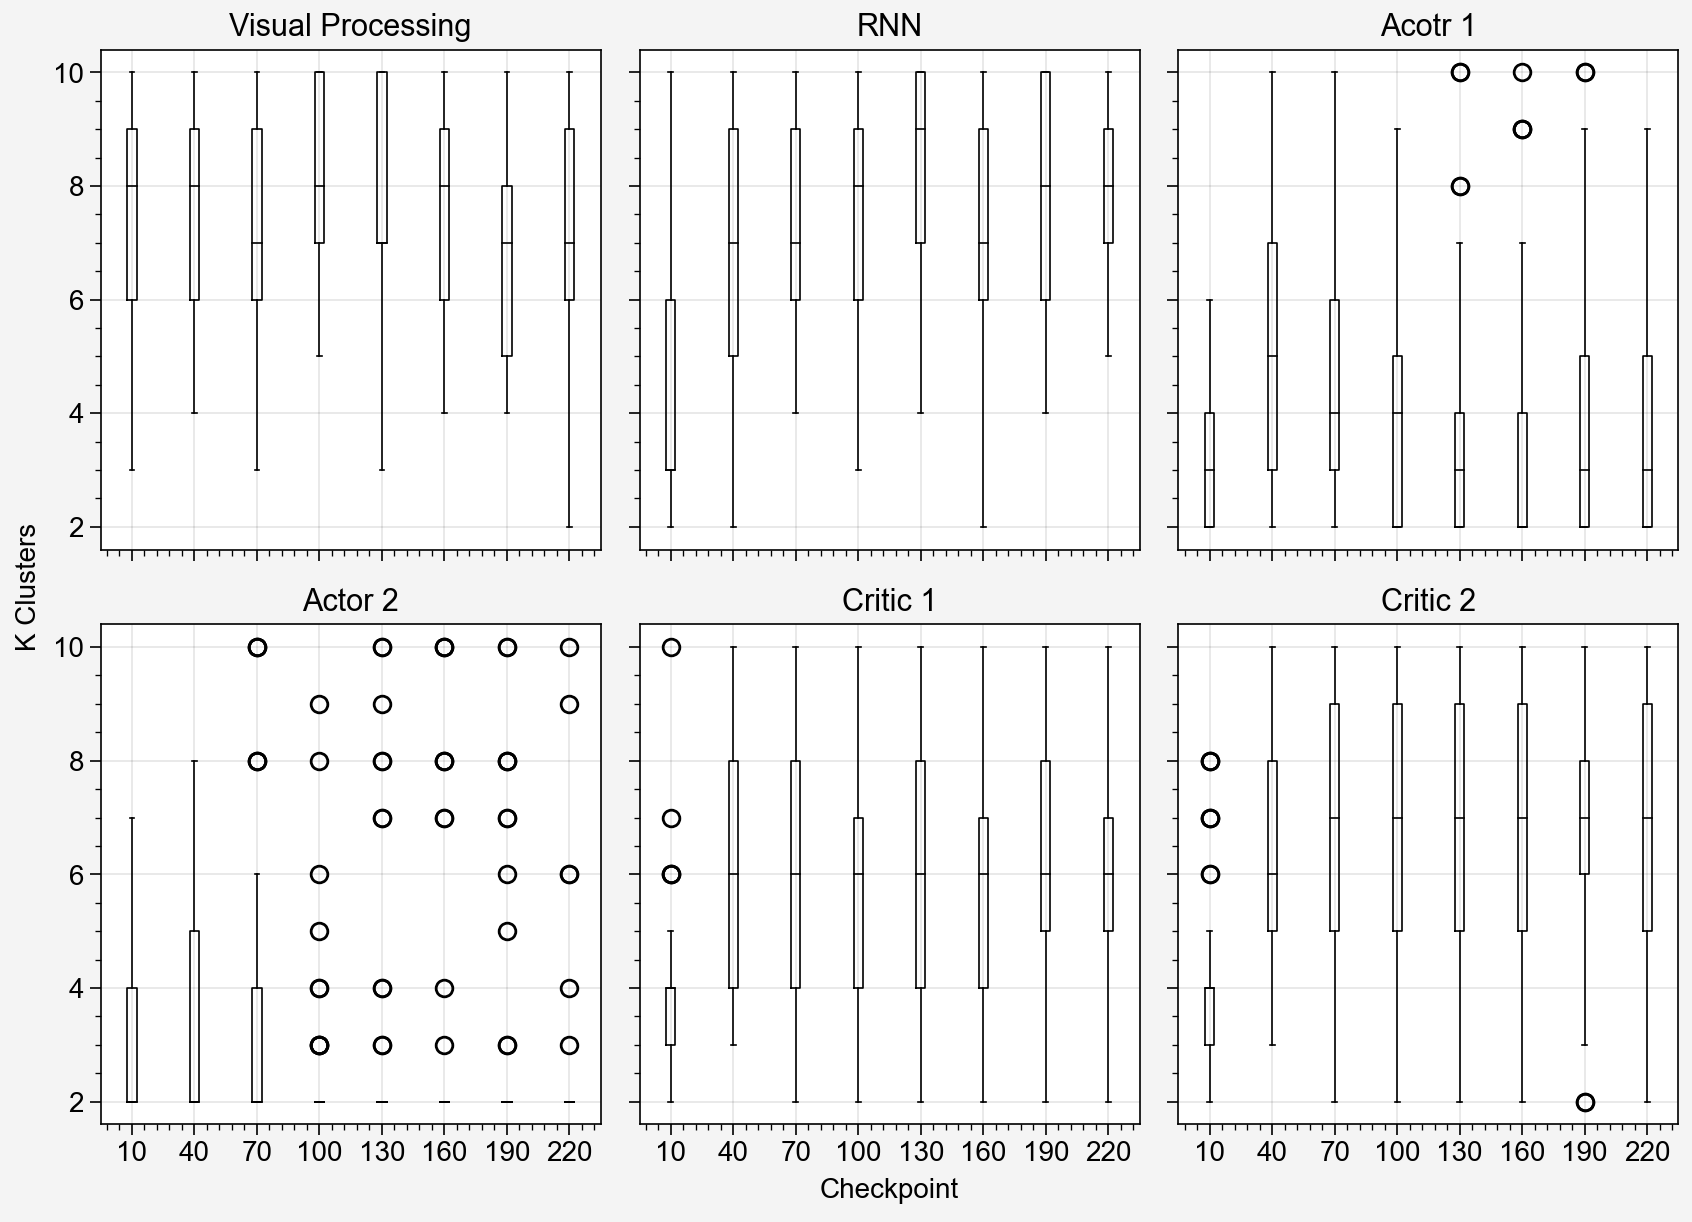

In [48]:
layers = ['shared0', 'shared1', 'actor0', 'actor1', 'critic0', 'critic1']
layer_labels = ['Visual Processing', 'RNN', 'Acotr 1', 'Actor 2', 'Critic 1', 'Critic 2']
fig, ax = pplt.subplots(nrows=2, ncols=3)

for i, layer in enumerate(layers):
    for j in range(8):
        x, y = i // 3, i % 3
        chk = chks[j]
        ax[x, y].boxplot(j, cluster_ks[:, :, :, j, i].flatten())
    ax[x, y].format(title=layer_labels[i])
ax.format(xlabel='Checkpoint', ylabel='K Clusters',
          xlocator=range(8), xformatter=[str(chks[j]) for j in range(8)])


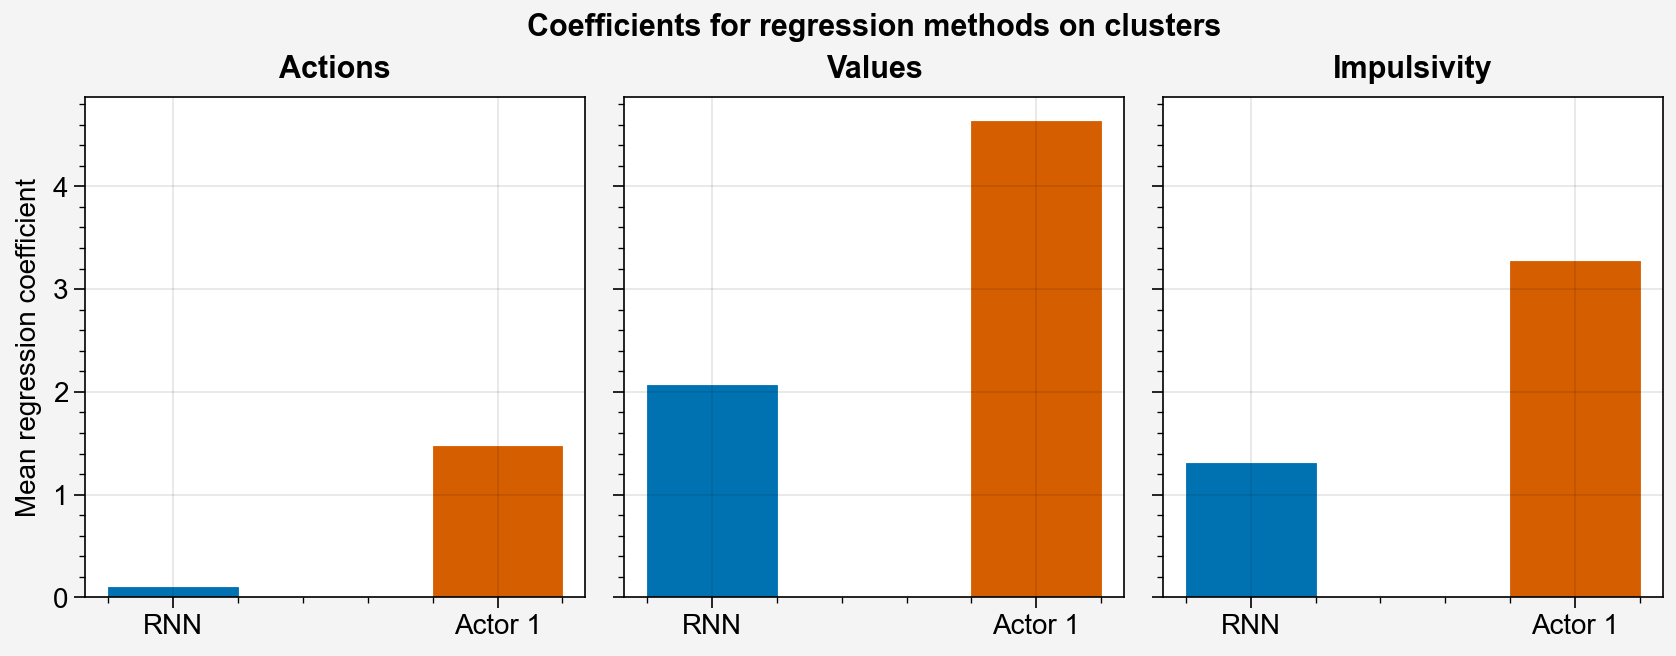

In [24]:
# nonzero_clusters coefs
fig, ax = pplt.subplots(ncols=3, sharex=True)
layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']
regressors = ['Actions', 'Values', 'Impulsivity']

num_agents = np.prod(cluster_regressor_coefs.shape[:4])
for i, layer in enumerate(layers):
    for j, regressor in enumerate(regressors):
        used_clusters = (cluster_regressor_coefs[:, :, :, :, i, j] != 0).sum()
        ax[j].bar(i, used_clusters / num_agents)

ax.format(xlocator=range(2), xformatter=layer_labels,
          ylabel='Mean regression coefficient',
          toplabels=regressors,
          suptitle='Coefficients for regression methods on clusters')
        

In [77]:
cluster_regressor_coefs = r['cluster_regressor_coefs'][1]

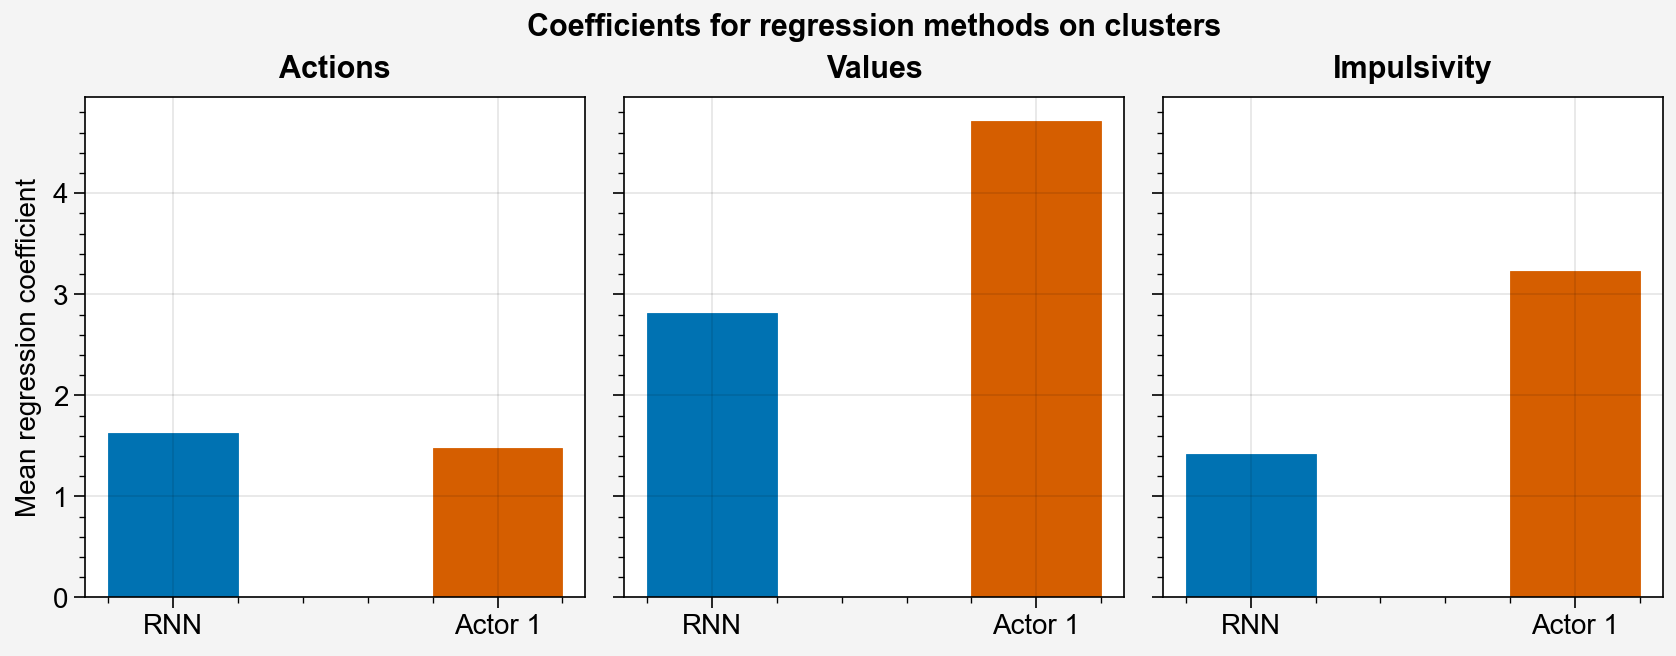

In [78]:
# nonzero_clusters coefs
fig, ax = pplt.subplots(ncols=3, sharex=True)
layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']
regressors = ['Actions', 'Values', 'Impulsivity']

num_agents = np.prod(cluster_regressor_coefs.shape[:4])
for i, layer in enumerate(layers):
    for j, regressor in enumerate(regressors):
        used_clusters = (cluster_regressor_coefs[:, :, :, :, i, j] != 0).sum()
        ax[j].bar(i, used_clusters / num_agents)

ax.format(xlocator=range(2), xformatter=layer_labels,
          ylabel='Mean regression coefficient',
          toplabels=regressors,
          suptitle='Coefficients for regression methods on clusters')
        

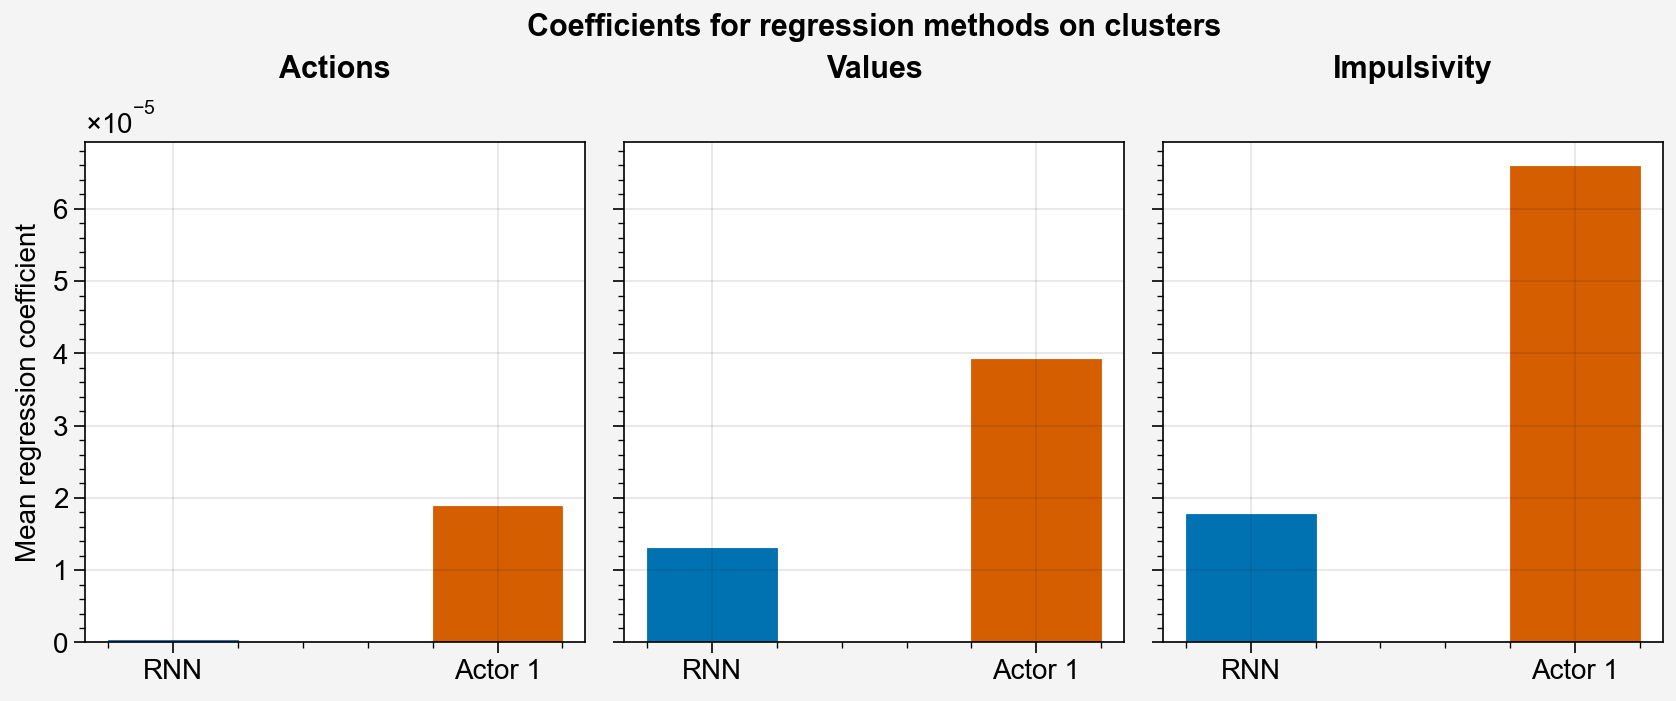

In [43]:
# nonzero_clusters coefs
fig, ax = pplt.subplots(ncols=3, sharex=True)
layers = [1, 2]
layer_labels = ['RNN', 'Actor 1']
regressors = ['Actions', 'Values', 'Impulsivity']

num_agents = np.prod(cluster_regressor_coefs.shape[:4])
for i, layer in enumerate(layers):
    for j, regressor in enumerate(regressors):
        used_clusters = np.abs(cluster_regressor_coefs[:, :, :, :, i, j]).mean()
        ax[j].bar(i, used_clusters / num_agents)

ax.format(xlocator=range(2), xformatter=layer_labels,
          ylabel='Mean regression coefficient',
          toplabels=regressors,
          suptitle='Coefficients for regression methods on clusters')
        

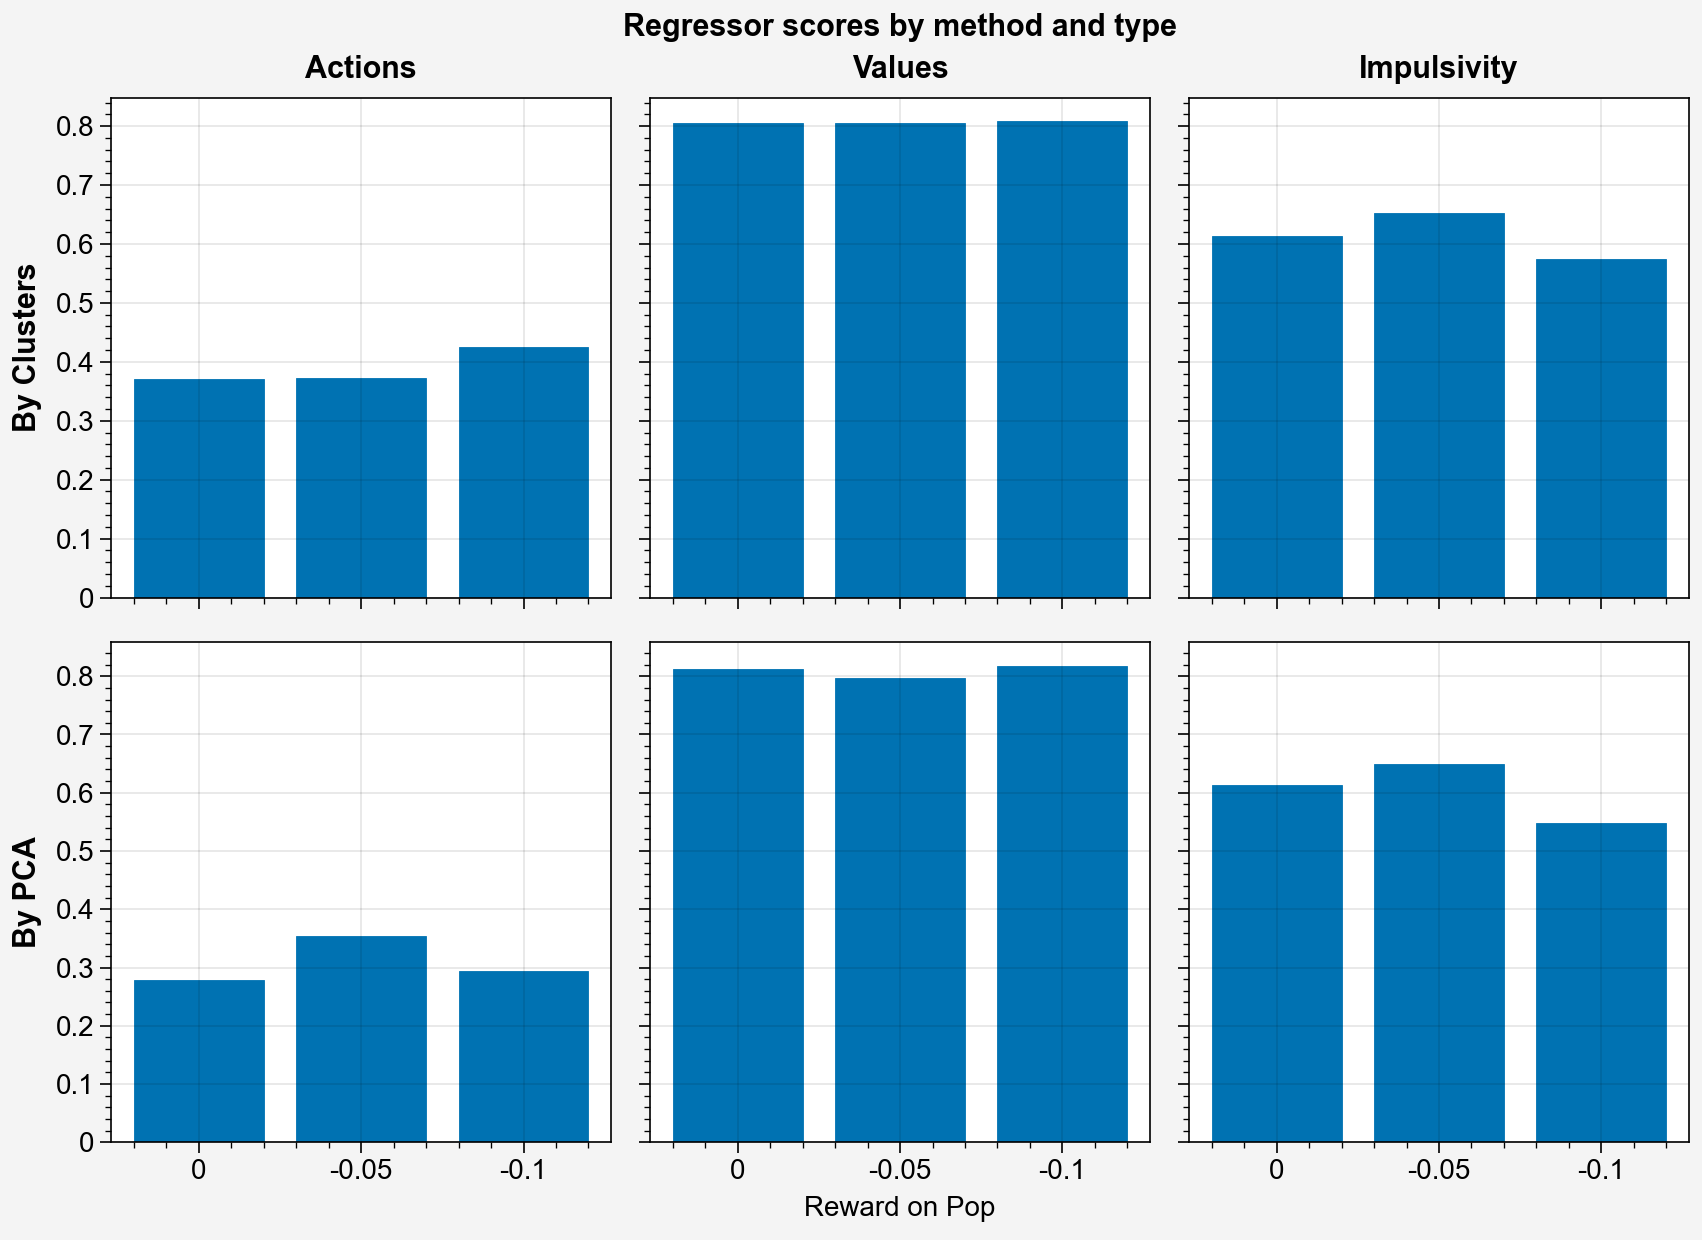

In [51]:
fig, ax = pplt.subplots(nrows=2, ncols=3)

for j in range(3):
    ax[0, j].bar(range(3), cluster_regressor_scores[:, :, :, :, 1, j].mean(axis=(1, 2, 3)))
    ax[1, j].bar(range(3), pca_regressor_scores[:, :, :, :, 1, j].mean(axis=(1, 2, 3)))

ax.format(xlabel='Reward on Pop', xlocator=range(3), xformatter=['0', '-0.05', '-0.1'],
          suptitle='Regressor scores by method and type',
    leftlabels=['By Clusters', 'By PCA'], toplabels=['Actions', 'Values', 'Impulsivity'])

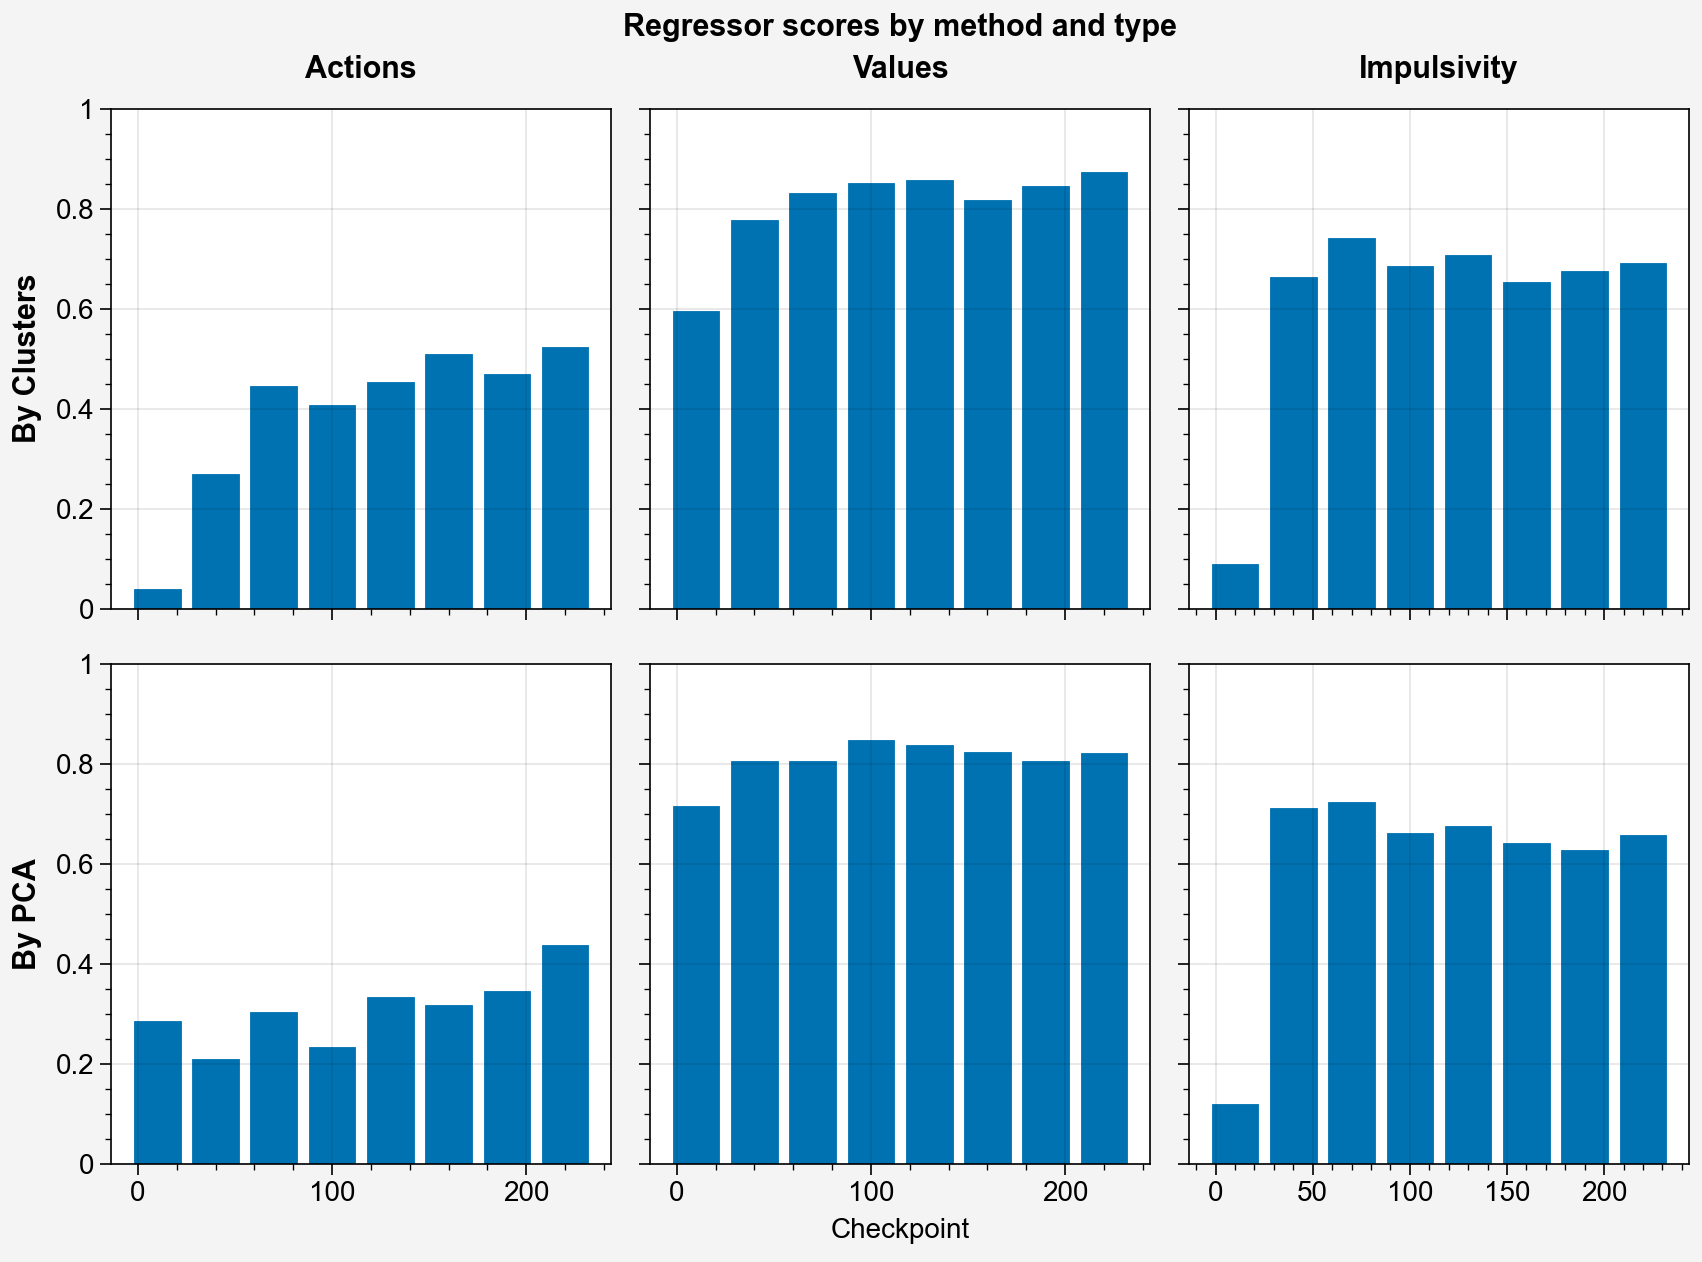

In [55]:
fig, ax = pplt.subplots(nrows=2, ncols=3)

for j in range(3):
    ax[0, j].bar(chks, cluster_regressor_scores[:, :, :, :, 1, j].mean(axis=(0, 1, 2)))
    ax[1, j].bar(chks, pca_regressor_scores[:, :, :, :, 1, j].mean(axis=(0, 1, 2)))

ax.format(xlabel='Checkpoint',
          suptitle='Regressor scores by method and type',
    leftlabels=['By Clusters', 'By PCA'], toplabels=['Actions', 'Values', 'Impulsivity'],
    ylim=[0, 1])

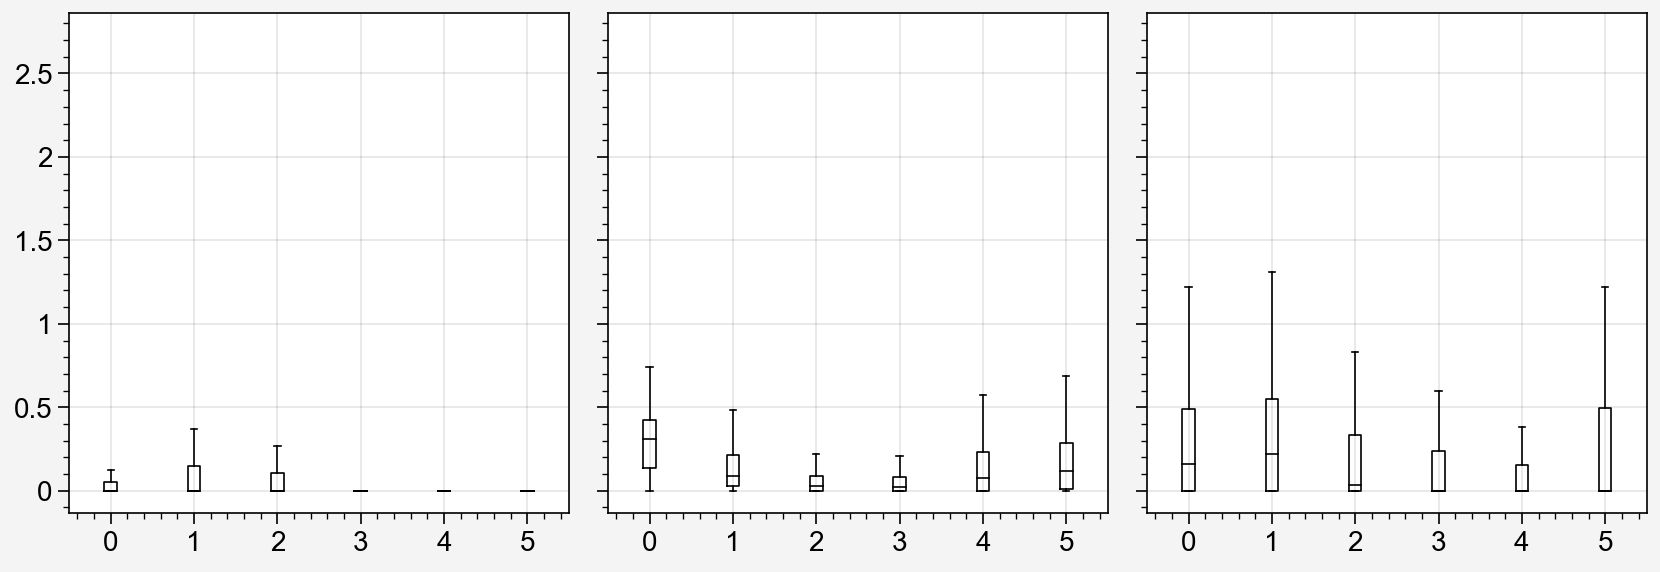

In [42]:
fig, ax = pplt.subplots(ncols=3)

for i in range(3):
    for j in range(6):
        ax[i].boxplot(j, np.abs(pca_regressor_coefs[:, :, :, :, 0, i, j].flatten()), fliers=False)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.8439119170984456, 0.9494910520657337, 0.674578299570773]


SubplotGrid(nrows=1, ncols=1, length=1)

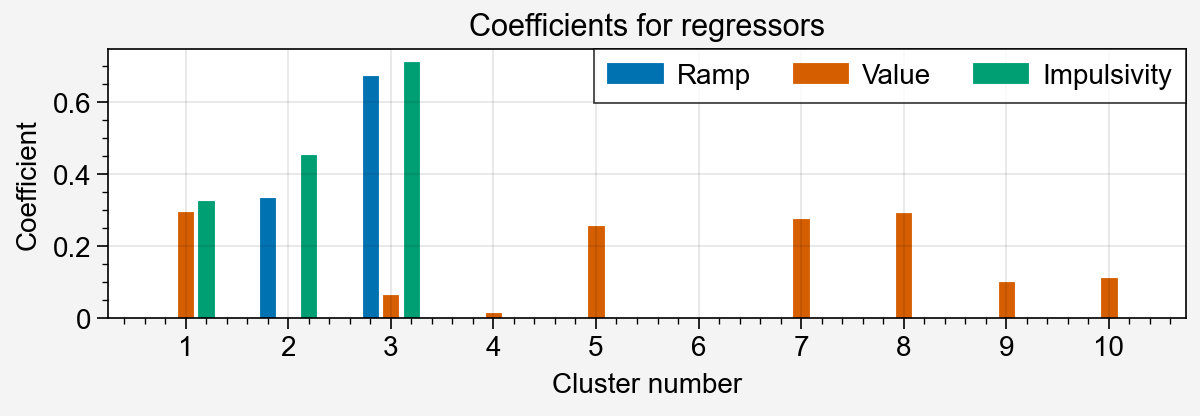

In [343]:
coefs, scores = compute_regressor_coefficients(res, by_clusters=False, layer='actor0')
print(scores)
visualize_regressor_coefficients(coefs)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.8150819672131148, 0.8723800874315504, 0.7014263627986277]


SubplotGrid(nrows=1, ncols=1, length=1)

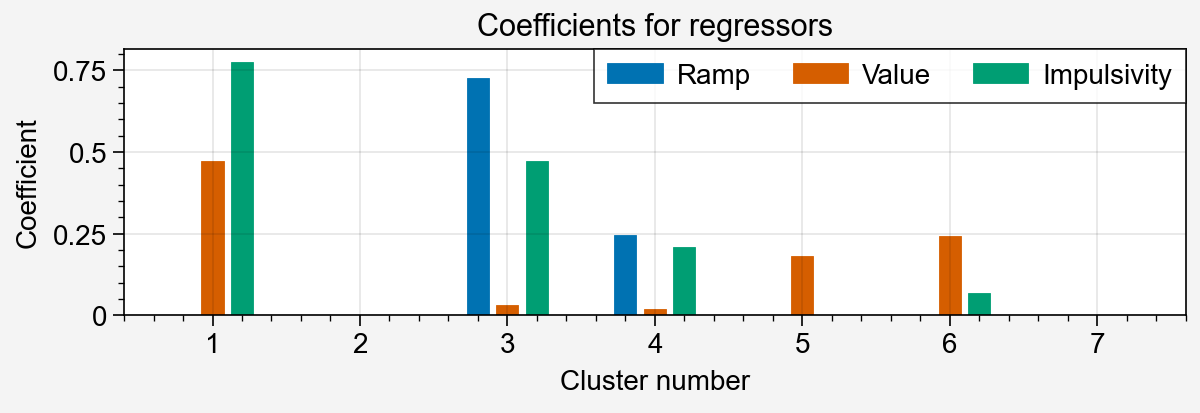

In [342]:
coefs, scores = compute_regressor_coefficients(res, by_clusters=True)
print(scores)
visualize_regressor_coefficients(coefs)

In [180]:
imp = get_impulsivity_data(res, load_global=False)
ap = imp['ap']
v = imp['v']
imp_steps = imp['imp_steps']
imp = ap[imp_steps]
imp = np.log(imp)
comb_activ = np.hstack([v,  cluster_activ])
lasso = LassoCV(cv=10, random_state=0, max_iter=100000, tol=0.001,
                alphas=np.logspace(-1, 0, 100))
lasso.fit(cluster_norm[imp_steps, :], imp)
ypred = lasso.predict(cluster_norm[imp_steps, :])
# lasso.fit(cluster_activ[imp_steps, :], imp)
# ypred = lasso.predict(cluster_activ[imp_steps, :])
# lasso.fit(comb_activ[imp_steps, :], imp)
# ypred = lasso.predict(comb_activ[imp_steps, :])
print('MSE', root_mean_squared_error(imp, ypred), 'R2', r2_score(imp, ypred))
print('alpha', lasso.alpha_)
lasso.coef_

MSE 0.8383728874786657 R2 0.6943165308011365
alpha 0.1


array([ 0.72847373,  0.        , -0.6677163 ,  0.        ,  0.        ,
        0.        , -0.15297074, -0.43513707,  0.        , -0.28379864])

In [146]:
alpha = lasso.alpha_
imp = get_impulsivity_data(res, load_global=False)
ap = imp['ap']
v = imp['v']
imp_steps = imp['imp_steps']
imp = ap[imp_steps]
comb_activ = np.hstack([v,  cluster_activ])
lm = Lasso(alpha=3e-4)
lm.fit(comb_activ[imp_steps, :], imp.reshape(-1, 1))
ypred = lm.predict(comb_activ[imp_steps, :])
print('MSE', root_mean_squared_error(imp, ypred), 'R2', r2_score(imp, ypred))
lm.coef_
print((lm.coef_ != 0).sum())

MSE 0.01677046927214852 R2 0.2820969056044048
4


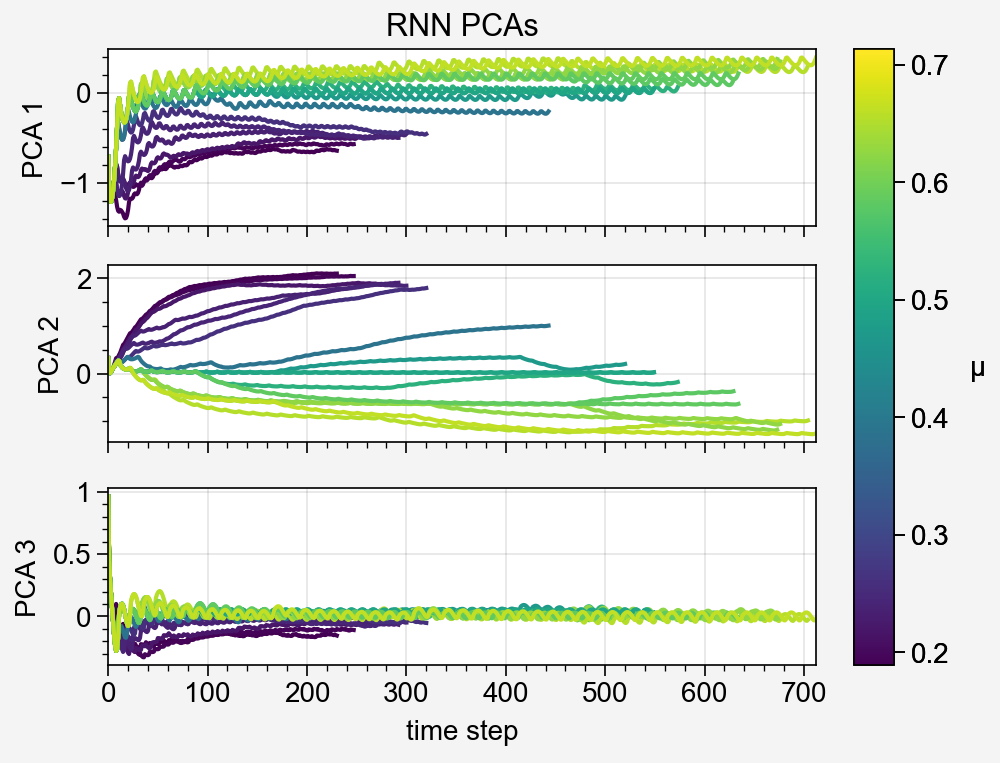

In [267]:
visualize_smoothed_pca_episodes(res)

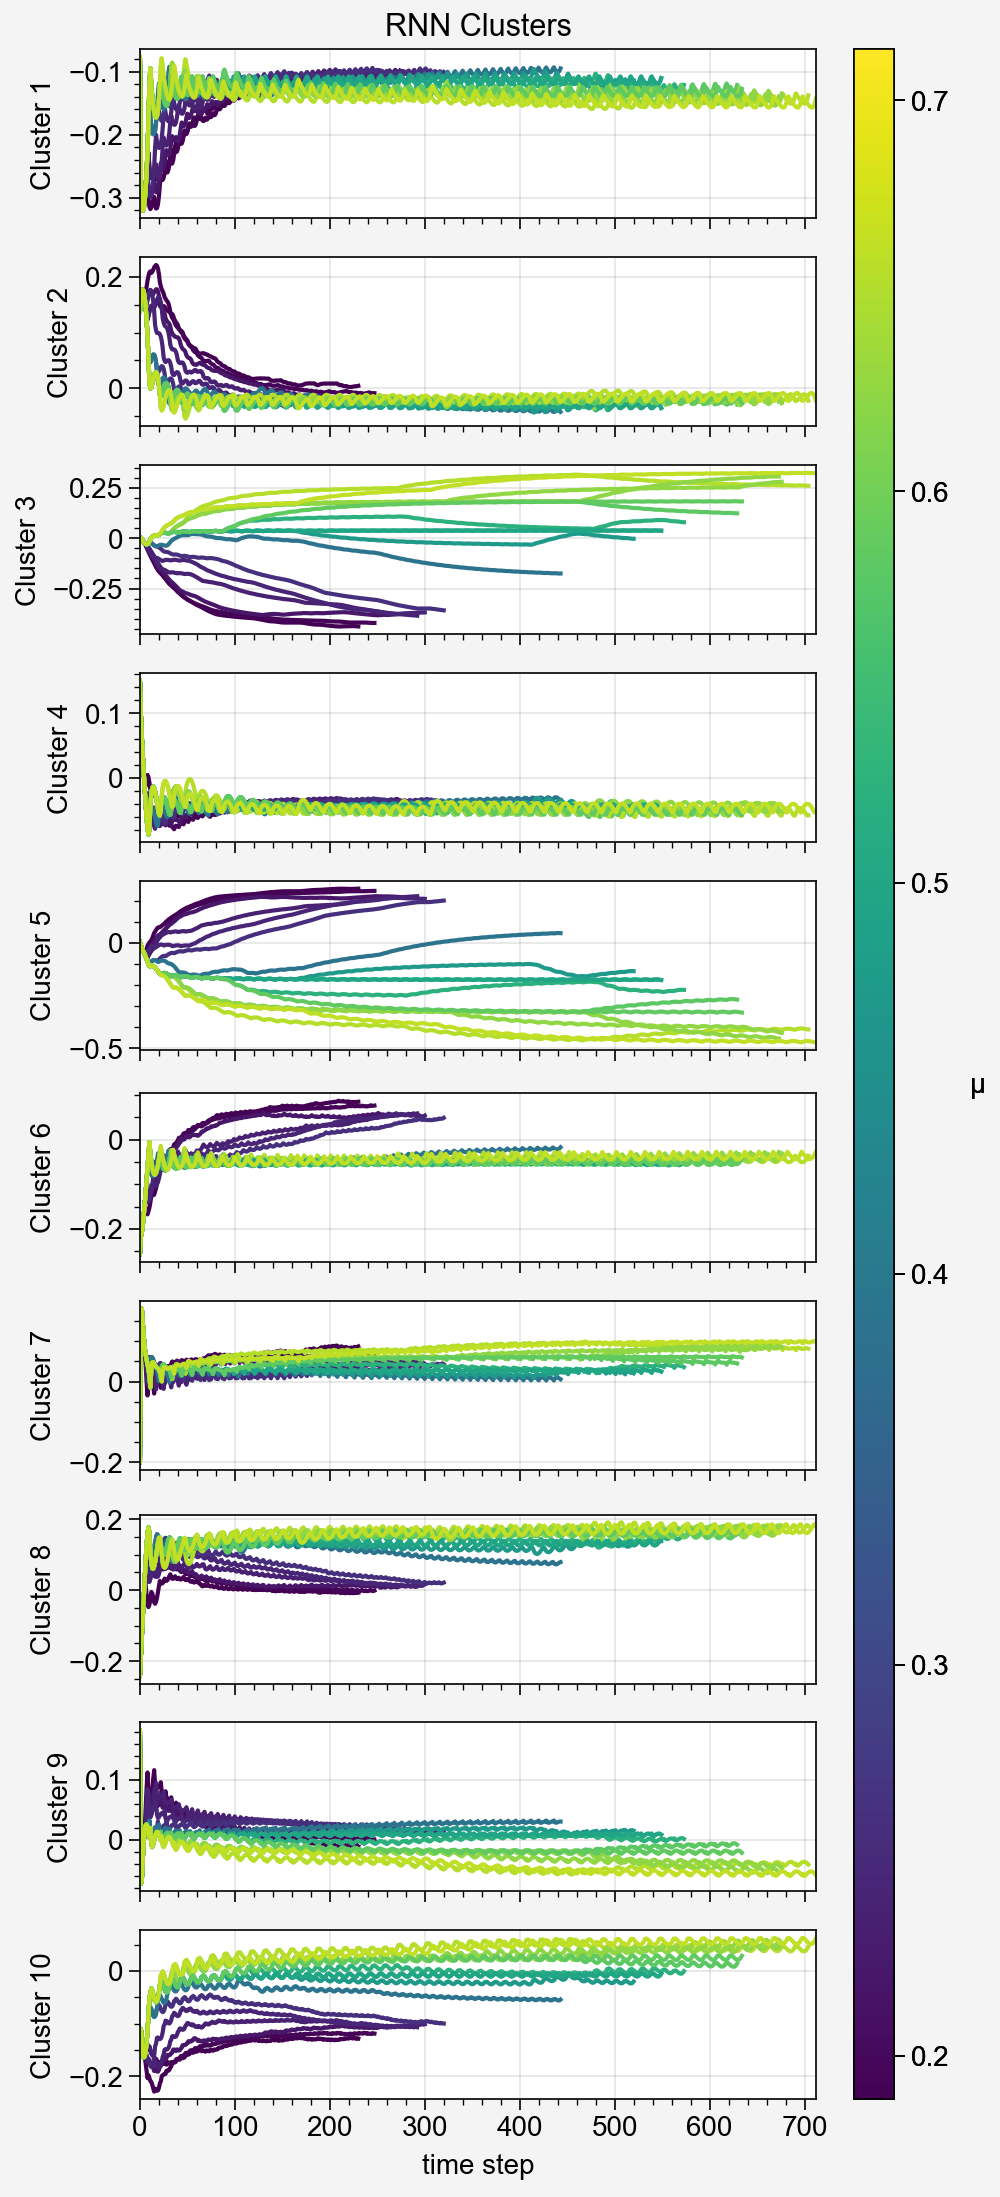

In [41]:
visualize_smoothed_cluster_episodes(res, labels)